#### Storage dispatch MILP

#### Final Storage Dispatch file and EV charging scheme

### Gurobi MILP

### MILP with ampereloading limits enforced

In [5]:
# file: storage_rpf_gurobi.py
import pyomo.environ as pyo
import pandas as pd
import numpy as np

# --- Load data ---
df = pd.read_csv("IEEE123Storage_Dispatch_with_cost.csv")
df.columns = [c.strip().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

T_idx = range(len(df))
RPF = df['RPF_Flag'].astype(int).to_dict()

# Convert negative export (Total_RPF < 0) to nonnegative availability (kW)
TotalRPF = {t: max(0.0, -float(df.loc[t, 'Total_RPF'])) for t in T_idx}  # kW available to charge when RPF=1
P_base = df['P_kW'].to_dict()
Q_base = df['Q_kvar'].to_dict()
Cost   = df['EnergyCost_USD_per_kWh'].to_dict()

# Optional measured voltages (exogenous)
V1 = df['V1'].to_dict(); V2 = df['V2'].to_dict(); V3 = df['V3'].to_dict()

# ================= Ampacity parameters (PCC) =================
VLL_nom_kV = 4.16       # PCC nominal line-to-line voltage (kV)
Imax_A     = 1500.0     # PCC ampacity (A)

# Build per-time conservative V_LL^min from per-phase pu voltages
# We assume V1,V2,V3 are phase-to-neutral per-unit magnitudes.
Vph_nom_kV = VLL_nom_kV / np.sqrt(3.0)

V1_pu = df['V1'].to_dict()
V2_pu = df['V2'].to_dict()
V3_pu = df['V3'].to_dict()

# Conservative lower bound on line-to-line voltage each hour (kV)
VLL_min_kV = {
    t: np.sqrt(3.0) * Vph_nom_kV * min(V1_pu[t], V2_pu[t], V3_pu[t])
    for t in T_idx
}

# Apparent power limit from ampacity each hour (kVA)
Smax_kVA = {t: np.sqrt(3.0) * VLL_min_kV[t] * Imax_A for t in T_idx}

# Precompute the real-power envelope Pmax_kW[t] from the ampacity circle
# Guard against negative radius if |Q_base| already exceeds Smax (-> Pmax=0)
Pmax_kW = {
    t: float(np.sqrt(max(0.0, Smax_kVA[t]**2 - (Q_base[t])**2)))
    for t in T_idx
}

# --- Parameters (kept from your base file) ---
Delta_t = 1.0                       # hour
E_min, E_max = 10000.0, 1000000.0   # kWh
eta_c, eta_d = 0.95, 0.95
P_cmax, P_dmax = 40000.0, 30000.0   # kW
Cost_thresh = 0.08                  # $/kWh
alpha = 1.0

# --- Model ---
m = pyo.ConcreteModel()
m.T = pyo.RangeSet(0, len(df)-1)

# Decision variables
m.Pc = pyo.Var(m.T, domain=pyo.NonNegativeReals)   # kW
m.Pd = pyo.Var(m.T, domain=pyo.NonNegativeReals)   # kW
m.E  = pyo.Var(m.T, bounds=(E_min, E_max))         # kWh
m.uc = pyo.Var(m.T, domain=pyo.Binary)             # 1 if charging
m.ud = pyo.Var(m.T, domain=pyo.Binary)             # 1 if discharging

# Initial SoC
m.E[0].fix(E_min)

# SoC dynamics with Δt
def soc_rule(m, t):
    if t == 0:
        return pyo.Constraint.Skip
    return m.E[t] == m.E[t-1] + eta_c*m.Pc[t-1]*Delta_t - (m.Pd[t-1]/eta_d)*Delta_t
m.soc_con = pyo.Constraint(m.T, rule=soc_rule)

# RPF charging cap: can only charge from available reverse power (and only when RPF flag is 1)
def rpf_cap_rule(m, t):
    return m.Pc[t] <= TotalRPF[t] * RPF[t]
m.rpf_cap = pyo.Constraint(m.T, rule=rpf_cap_rule)

# Power caps and mutual exclusivity
m.Pc_cap = pyo.Constraint(m.T, rule=lambda m,t: m.Pc[t] <= P_cmax * m.uc[t])
m.Pd_cap = pyo.Constraint(m.T, rule=lambda m,t: m.Pd[t] <= P_dmax * m.ud[t])
m.mutex  = pyo.Constraint(m.T, rule=lambda m,t: m.uc[t] + m.ud[t] <= 1)

# Discharge only when price is high AND there is no RPF (policy)
def high_cost_cap(m, t):
    if (Cost[t] > Cost_thresh) and (RPF[t] == 0):
        return m.Pd[t] <= max(0.0, P_base[t])
    return pyo.Constraint.Skip
m.high_cost_cap = pyo.Constraint(m.T, rule=high_cost_cap)

# ================= Add linear ampacity constraints to the model =================
# Net PCC real power after storage
m.Pnet = pyo.Expression(m.T, rule=lambda m, t: P_base[t] + m.Pc[t] - m.Pd[t])

# Two-sided linear bound: -Pmax <= Pnet <= Pmax
m.amp_up = pyo.Constraint(m.T, rule=lambda m, t:  m.Pnet[t] <= Pmax_kW[t])
m.amp_lo = pyo.Constraint(m.T, rule=lambda m, t: -m.Pnet[t] <= Pmax_kW[t])

# NOTE: We intentionally do NOT add constraints like V_min <= V1[t] because V1[t] is a constant;
# Pyomo would treat it as a boolean and error out. Ex-post validation is recommended.

# Objective with Δt
def obj(m):
    term_charge = sum(m.Pc[t] * RPF[t] * Delta_t for t in m.T)
    term_discharge = sum(alpha * m.Pd[t] * Cost[t] * Delta_t
                         for t in m.T if (Cost[t] > Cost_thresh and RPF[t]==0))
    return term_charge + term_discharge
m.obj = pyo.Objective(rule=obj, sense=pyo.maximize)

# --------- Gurobi solver setup ----------
opt = pyo.SolverFactory('gurobi')

# Common practical options (tune to your environment):
opt.options['MIPGap']    = 0.02      # stop when 2% gap achieved
opt.options['TimeLimit'] = 1800      # seconds (30 minutes)
opt.options['Threads']   = 8         # adjust to your CPU
opt.options['Heuristics']= 0.5       # use primal heuristics
opt.options['MIPFocus']  = 1         # focus more on finding good incumbents
opt.options['Presolve']  = 2         # aggressive presolve
opt.options['Cuts']      = 2         # moderate cuts

# Solve
res = opt.solve(m, tee=True)

# Report
print(res.solver.status, res.solver.termination_condition)

# Export results
out = df.copy()
out['P_c_kW'] = [pyo.value(m.Pc[t]) for t in m.T]
out['P_d_kW'] = [pyo.value(m.Pd[t]) for t in m.T]
out['E_kWh']  = [pyo.value(m.E[t])  for t in m.T]
out['Pnet_kW'] = [pyo.value(m.Pnet[t]) for t in m.T]
out['Pmax_kW'] = [Pmax_kW[t] for t in m.T]
out.to_csv('IEEE123Storage_Dispatch_solution_gurobi.csv', index=False)
print('Saved: IEEE123Storage_Dispatch_solution_gurobi.csv')

Read LP format model from file C:\Users\UCHENONU\AppData\Local\Temp\tmp5328wize.pyomo.lp
Reading time = 0.13 seconds
x1: 62779 rows, 43799 columns, 132855 nonzeros
Set parameter MIPGap to value 0.02
Set parameter TimeLimit to value 1800
Set parameter Threads to value 8
Set parameter Heuristics to value 0.5
Set parameter MIPFocus to value 1
Set parameter Presolve to value 2
Set parameter Cuts to value 2
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-10850H CPU @ 2.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  1800
MIPGap  0.02
Heuristics  0.5
MIPFocus  1
Cuts  2
Presolve  2
Threads  8

Optimize a model with 62779 rows, 43799 columns and 132855 nonzeros
Model fingerprint: 0x915f58cf
Variable types: 26279 continuous, 17520 integer (17520 binary)
Coefficient statistics:
  Matrix range     [9e-01, 4e+04]
  Objective ran

#### Quick checks to confirm ampacity is enforced correctly

In [8]:
import pandas as pd
sol = pd.read_csv("IEEE123Storage_Dispatch_solution_gurobi.csv")
viol = sol[(sol['Pnet_kW'] > sol['Pmax_kW'] + 1e-6) | (sol['Pnet_kW'] < -sol['Pmax_kW'] - 1e-6)]
print("Violating rows:", len(viol))

Violating rows: 0


In [10]:
bind = sol[(sol['Pmax_kW'] > 0) & (sol['Pmax_kW'] - sol['Pnet_kW']).abs() < 1e-3]
print("Ampacity-binding hours:", len(bind))

Ampacity-binding hours: 2


In [12]:
import pandas as pd
import numpy as np

sol = pd.read_csv("IEEE123Storage_Dispatch_solution_gurobi.csv")

# Tolerance for "bind"
tol = 1e-3

# Identify binding rows
bind = sol[(sol['Pmax_kW'] > 0) & (sol['Pmax_kW'] - sol['Pnet_kW']).abs() < tol].copy()

# Classify side (+Pmax or -Pmax)
bind['which_side'] = np.where(
    (bind['Pmax_kW'] - bind['Pnet_kW']).abs() < tol,
    np.where(bind['Pnet_kW'] >= 0, '+Pmax', '-Pmax'),
    'none'
)

cols = ['Time_stamp', 'Pnet_kW', 'Pmax_kW', 'which_side', 'P_c_kW', 'P_d_kW', 'E_kWh']
print(bind[cols].to_string(index=False))

 Time_stamp  Pnet_kW  Pmax_kW which_side  P_c_kW  P_d_kW         E_kWh
07-22 13:00      0.0      0.0      +Pmax 31825.0     0.0 673215.725142
07-22 14:00      0.0      0.0      +Pmax  9067.1     0.0 703449.475142


### Plots with Ampere loading constraint

C:\Users\UCHENONU\AppData\Local\Temp\ipykernel_3844\3220166444.py:39: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)
C:\Users\UCHENONU\AppData\Local\Temp\ipykernel_3844\3220166444.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)


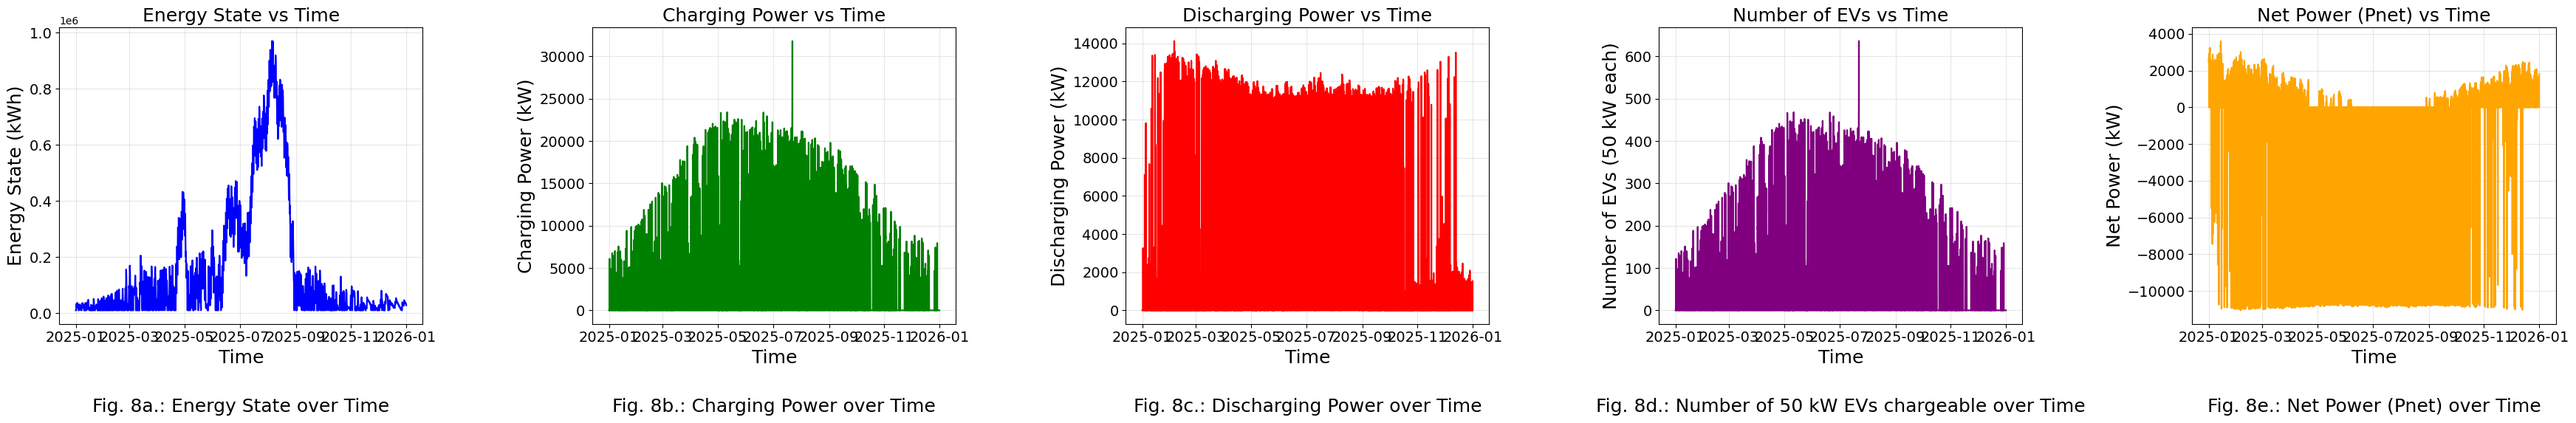

Saved figure to: gurobi_dispatch_subplots_with_pnet.png


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ==============================
# User parameters
# ==============================
csv_path = "IEEE123Storage_Dispatch_solution_gurobi.csv"
year_for_datetime = 2025           # used if we need to append a year to a month-day timestamp
ev_power_kW = 50.0                 # rating per EV for "Number_of_EVs" calculation
figure_path = "gurobi_dispatch_subplots_with_pnet.png"

# ==============================
# Load and clean
# ==============================
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Normalize likely column names from the optimization output
required_cols = ['P_c_kW', 'P_d_kW', 'E_kWh']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in {csv_path}")

# --- Pnet is optional but recommended for the new subplot
has_pnet = 'Pnet_kW' in df.columns
if not has_pnet:
    raise ValueError("Column 'Pnet_kW' not found in the CSV. Please ensure the file includes net power.")

# --- Build/parse Time column robustly ---
time_col = None
for cand in ['Time_stamp', 'timestamp', 'time', 'Time', 'Datetime', 'DateTime']:
    if cand in df.columns:
        time_col = cand
        break

if time_col is not None:
    try:
        ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)
    except Exception:
        ts = pd.to_datetime(
            df[time_col].astype(str) + f' {year_for_datetime}',
            format='%m-%d %H:%M %Y',
            errors='coerce'
        )
        if ts.isna().any():
            ts = pd.to_datetime(df[time_col], errors='coerce')
    df['Time_dt'] = ts
else:
    print("No explicit time column found; creating synthetic hourly timeline.")
    start = pd.Timestamp(year_for_datetime, 1, 1, 0, 0)
    df['Time_dt'] = [start + timedelta(hours=i) for i in range(len(df))]

# Ensure sorted by time (just in case)
df = df.sort_values('Time_dt').reset_index(drop=True)

# ==============================
# Derived quantities
# ==============================
df['Number_of_EVs'] = df['P_c_kW'] / ev_power_kW

series_time = df['Time_dt']
series_energy = df['E_kWh']
series_charge = df['P_c_kW']
series_discharge = df['P_d_kW']
series_nevs = df['Number_of_EVs']
series_pnet = df['Pnet_kW']  # NEW

# ==============================
# Plotting
# ==============================
# Style settings
title_fontsize = 18
label_fontsize = 18
tick_fontsize = 14
caption_fontsize = 18

# Expand to 1x5 to add the Pnet subplot
fig, axs = plt.subplots(1, 5, figsize=(35, 6), sharex=True)

# Energy State vs Time
axs[0].plot(series_time, series_energy, color='blue', linewidth=1.6)
axs[0].set_title('Energy State vs Time', fontsize=title_fontsize)
axs[0].set_xlabel('Time', fontsize=label_fontsize)
axs[0].set_ylabel('Energy State (kWh)', fontsize=label_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)
axs[0].grid(True, alpha=0.3)
axs[0].text(0.5, -0.28, 'Fig. 8a.: Energy State over Time', ha='center', va='center',
            transform=axs[0].transAxes, fontsize=caption_fontsize)

# Charging Power vs Time
axs[1].plot(series_time, series_charge, color='green', linewidth=1.6)
axs[1].set_title('Charging Power vs Time', fontsize=title_fontsize)
axs[1].set_xlabel('Time', fontsize=label_fontsize)
axs[1].set_ylabel('Charging Power (kW)', fontsize=label_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)
axs[1].grid(True, alpha=0.3)
axs[1].text(0.5, -0.28, 'Fig. 8b.: Charging Power over Time', ha='center', va='center',
            transform=axs[1].transAxes, fontsize=caption_fontsize)

# Discharging Power vs Time
axs[2].plot(series_time, series_discharge, color='red', linewidth=1.6)
axs[2].set_title('Discharging Power vs Time', fontsize=title_fontsize)
axs[2].set_xlabel('Time', fontsize=label_fontsize)
axs[2].set_ylabel('Discharging Power (kW)', fontsize=label_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)
axs[2].grid(True, alpha=0.3)
axs[2].text(0.5, -0.28, 'Fig. 8c.: Discharging Power over Time', ha='center', va='center',
            transform=axs[2].transAxes, fontsize=caption_fontsize)

# Number of EVs vs Time
axs[3].plot(series_time, series_nevs, color='purple', linewidth=1.6)
axs[3].set_title('Number of EVs vs Time', fontsize=title_fontsize)
axs[3].set_xlabel('Time', fontsize=label_fontsize)
axs[3].set_ylabel(f'Number of EVs ({int(ev_power_kW)} kW each)', fontsize=label_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)
axs[3].grid(True, alpha=0.3)
axs[3].text(0.5, -0.28, f'Fig. 8d.: Number of {int(ev_power_kW)} kW EVs chargeable over Time',
            ha='center', va='center', transform=axs[3].transAxes, fontsize=caption_fontsize)

# NEW: Net Power (Pnet) vs Time
axs[4].plot(series_time, series_pnet, color='orange', linewidth=1.6)
axs[4].set_title('Net Power (Pnet) vs Time', fontsize=title_fontsize)
axs[4].set_xlabel('Time', fontsize=label_fontsize)
axs[4].set_ylabel('Net Power (kW)', fontsize=label_fontsize)
axs[4].tick_params(axis='both', labelsize=tick_fontsize)
axs[4].grid(True, alpha=0.3)
axs[4].text(0.5, -0.28, 'Fig. 8e.: Net Power (Pnet) over Time', ha='center', va='center',
            transform=axs[4].transAxes, fontsize=caption_fontsize)

plt.tight_layout()
plt.savefig(figure_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {figure_path}")


##### Presentation Plots

C:\Users\UCHENONU\AppData\Local\Temp\ipykernel_6932\2720557394.py:58: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)
C:\Users\UCHENONU\AppData\Local\Temp\ipykernel_6932\2720557394.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)


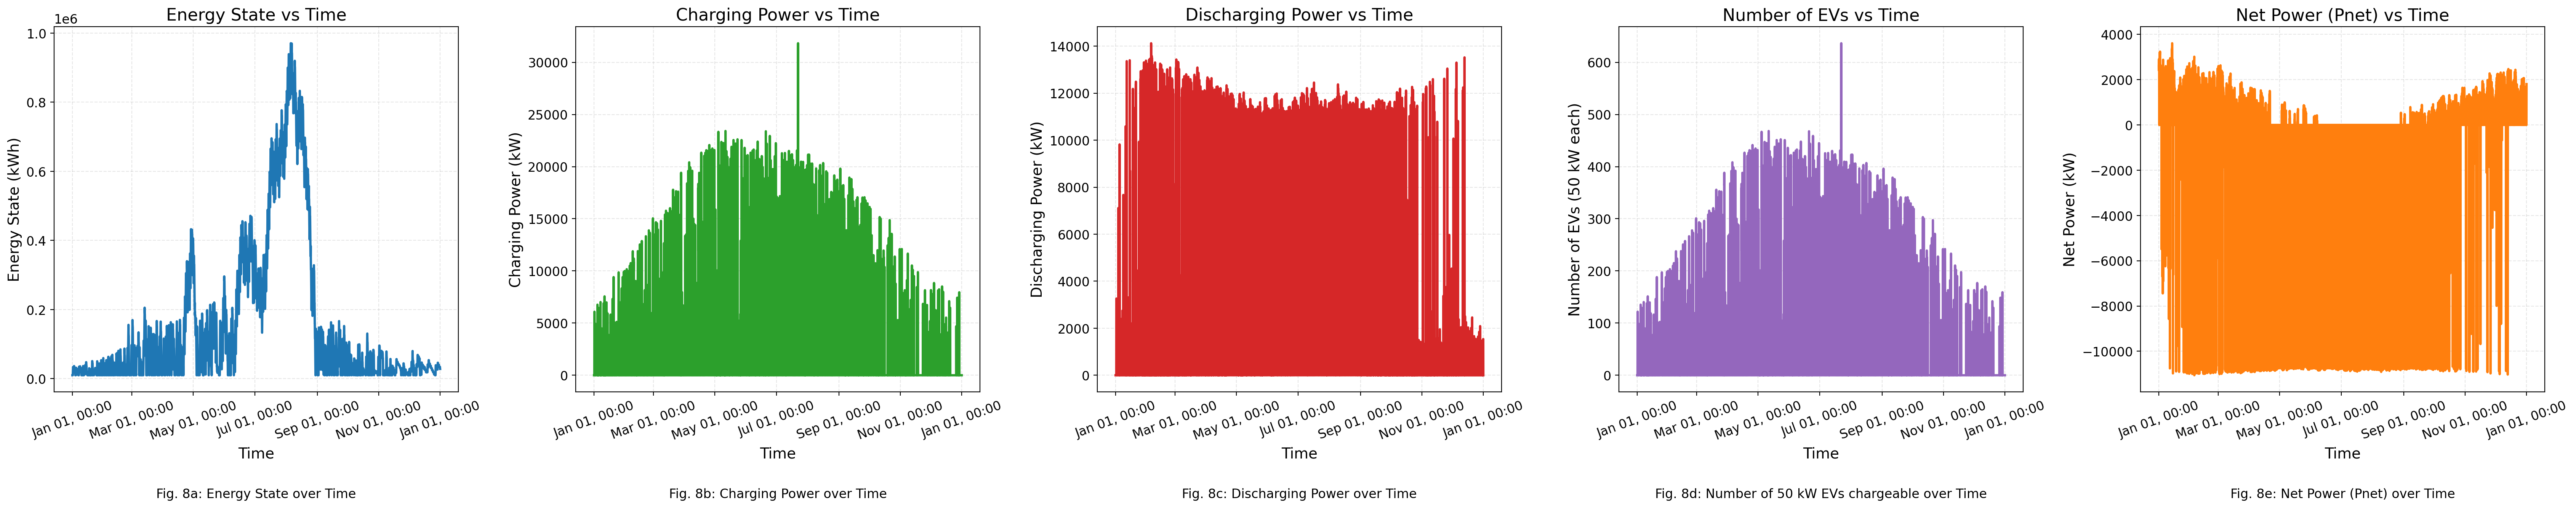

Saved figure to: gurobi_dispatch_subplots_with_pnet.png


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter, AutoDateLocator
from datetime import timedelta
import numpy as np

# ==============================
# Presentation: legible fonts & high resolution
# ==============================
mpl.rcParams['figure.dpi'] = 200            # On-screen clarity
mpl.rcParams['savefig.dpi'] = 300           # Export clarity (print-quality)
mpl.rcParams['font.family'] = 'DejaVu Sans' # Readable default; change to 'Arial' if preferred
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.3

# ==============================
# User parameters
# ==============================
csv_path = "IEEE123Storage_Dispatch_solution_gurobi.csv"
year_for_datetime = 2025           # used if we need to append a year to a month-day timestamp
ev_power_kW = 50.0                 # rating per EV for "Number_of_EVs" calculation
figure_path = "gurobi_dispatch_subplots_with_pnet.png"

# ==============================
# Load and clean
# ==============================
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Normalize likely column names from the optimization output
required_cols = ['P_c_kW', 'P_d_kW', 'E_kWh']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' not found in {csv_path}")

# --- Pnet is optional but recommended for the new subplot
has_pnet = 'Pnet_kW' in df.columns
if not has_pnet:
    raise ValueError("Column 'Pnet_kW' not found in the CSV. Please ensure the file includes net power.")

# --- Build/parse Time column robustly ---
time_col = None
for cand in ['Time_stamp', 'timestamp', 'time', 'Time', 'Datetime', 'DateTime']:
    if cand in df.columns:
        time_col = cand
        break

if time_col is not None:
    try:
        ts = pd.to_datetime(df[time_col], errors='raise', infer_datetime_format=True)
    except Exception:
        # Try appending a year if the format is like 'MM-DD HH:MM'
        ts = pd.to_datetime(
            df[time_col].astype(str) + f' {year_for_datetime}',
            format='%m-%d %H:%M %Y',
            errors='coerce'
        )
        if ts.isna().any():
            ts = pd.to_datetime(df[time_col], errors='coerce')
    df['Time_dt'] = ts
else:
    print("No explicit time column found; creating synthetic hourly timeline.")
    start = pd.Timestamp(year_for_datetime, 1, 1, 0, 0)
    df['Time_dt'] = [start + timedelta(hours=i) for i in range(len(df))]

# Ensure sorted by time (just in case)
df = df.sort_values('Time_dt').reset_index(drop=True)

# ==============================
# Derived quantities
# ==============================
df['Number_of_EVs'] = df['P_c_kW'] / ev_power_kW

series_time     = df['Time_dt']
series_energy   = df['E_kWh']
series_charge   = df['P_c_kW']
series_discharge= df['P_d_kW']
series_nevs     = df['Number_of_EVs']
series_pnet     = df['Pnet_kW']  # NEW

# ==============================
# Plotting (1x5 subplots; shared x-axis)
# ==============================
fig, axs = plt.subplots(1, 5, figsize=(34, 7), sharex=True)

# Common date formatter for x-axis
locator = AutoDateLocator(minticks=6, maxticks=10)
formatter = DateFormatter('%b %d, %H:%M')  # e.g., 'Jan 03, 14:30'

def style_axis(ax):
    ax.grid(True)
    ax.tick_params(axis='x', labelrotation=20)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Energy State vs Time
axs[0].plot(series_time, series_energy, color='#1f77b4', linewidth=2.2)
axs[0].set_title('Energy State vs Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Energy State (kWh)')
style_axis(axs[0])
axs[0].text(0.5, -0.28, 'Fig. 8a: Energy State over Time', ha='center', va='center',
            transform=axs[0].transAxes)

# Charging Power vs Time
axs[1].plot(series_time, series_charge, color='#2ca02c', linewidth=2.2)
axs[1].set_title('Charging Power vs Time')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Charging Power (kW)')
style_axis(axs[1])
axs[1].text(0.5, -0.28, 'Fig. 8b: Charging Power over Time', ha='center', va='center',
            transform=axs[1].transAxes)

# Discharging Power vs Time
axs[2].plot(series_time, series_discharge, color='#d62728', linewidth=2.2)
axs[2].set_title('Discharging Power vs Time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Discharging Power (kW)')
style_axis(axs[2])
axs[2].text(0.5, -0.28, 'Fig. 8c: Discharging Power over Time', ha='center', va='center',
            transform=axs[2].transAxes)

# Number of EVs vs Time
axs[3].plot(series_time, series_nevs, color='#9467bd', linewidth=2.2)
axs[3].set_title('Number of EVs vs Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel(f'Number of EVs ({int(ev_power_kW)} kW each)')
style_axis(axs[3])
axs[3].text(0.5, -0.28, f'Fig. 8d: Number of {int(ev_power_kW)} kW EVs chargeable over Time',
            ha='center', va='center', transform=axs[3].transAxes)

# NEW: Net Power (Pnet) vs Time
axs[4].plot(series_time, series_pnet, color='#ff7f0e', linewidth=2.2)
axs[4].set_title('Net Power (Pnet) vs Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Net Power (kW)')
style_axis(axs[4])
axs[4].text(0.5, -0.28, 'Fig. 8e: Net Power (Pnet) over Time', ha='center', va='center',
            transform=axs[4].transAxes)

# Layout & export
plt.tight_layout()
plt.savefig(figure_path, bbox_inches='tight')  # high-res export by rcParams
plt.show()

print(f"Saved figure to: {figure_path}")


### KPIs Computation/evaluation

In [18]:
# kpi_storage_rpf.py
# Evaluates KPIs for the storage_rpf_gurobi.py solution.

import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

# ------------------- USER SETTINGS (match your model) -------------------
DATA_CSV      = "IEEE123Storage_Dispatch_with_cost.csv"
SOLUTION_CSV  = "IEEE123Storage_Dispatch_solution_gurobi.csv"
OUTPUT_SUMMARY_JSON = "KPIs_summary.json"
OUTPUT_TS_CSV       = "KPIs_timeseries.csv"

# Model parameters (should match the ones used in optimization)
DELTA_T_H       = 1.0
ETA_C           = 0.95
ETA_D           = 0.95
P_CMAX          = 40000.0
P_DMAX          = 30000.0
COST_THRESH     = 0.08
ALPHA           = 1.0

# Ampacity settings (match what you enforced)
VLL_NOM_KV = 4.16
IMAX_A     = 1500.0
PU_FLOOR   = None   # if  used a fixed floor is used; else None to mimic measured VLL_min
# -----------------------------------------------------------------------

def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns]
    return df

def compute_VLL_min_kV(row, vll_nom_kV, pu_floor=None):
    if pu_floor is not None:
        return vll_nom_kV * float(pu_floor)
    return vll_nom_kV * min(float(row["V1"]), float(row["V2"]), float(row["V3"]))

def compute_Smax_kVA(VLL_min_kV, Imax_A):
    return math.sqrt(3.0) * VLL_min_kV * Imax_A

def compute_Pmax_kW(Smax_kVA, Q_base_kvar):
    rad2 = max(0.0, (Smax_kVA**2) - (float(Q_base_kvar)**2))
    return math.sqrt(rad2)

def main():
    # ----------------- Load inputs -----------------
    data = _clean_cols(pd.read_csv(DATA_CSV))
    sol  = _clean_cols(pd.read_csv(SOLUTION_CSV))
    if len(data) != len(sol):
        raise ValueError(f"Row mismatch: data={len(data)} vs solution={len(sol)}")

    nT = len(data)
    T  = np.arange(nT)

    # Merge the data we need into a single frame (aligned by row)
    df = data.join(sol[["P_c_kW","P_d_kW","E_kWh","Pnet_kW","Pmax_kW"]])

    # -------------- Derived masks & helpers --------------
    # Policy set for discharge: Hi-price & no-RPF
    mask_hi = (df["EnergyCost_USD_per_kWh"] > COST_THRESH) & (df["RPF_Flag"] == 0)

    # TotalRPF availability (nonnegative kW), as in the model
    TotalRPF = np.maximum(0.0, -df["Total_RPF"].astype(float).values)
    df["TotalRPF_kW"] = TotalRPF

    # VLL_min & Smax recompute (for diagnostics) – mirrors model construction
    VLL_min_kV = []
    Smax_kVA   = []
    Pmax_chk   = []
    for _, r in df.iterrows():
        vll_min = compute_VLL_min_kV(r, VLL_NOM_KV, PU_FLOOR)
        smax    = compute_Smax_kVA(vll_min, IMAX_A)
        pmax    = compute_Pmax_kW(smax, r["Q_kvar"])
        VLL_min_kV.append(vll_min)
        Smax_kVA.append(smax)
        Pmax_chk.append(pmax)

    df["VLL_min_kV"] = VLL_min_kV
    df["Smax_kVA"]   = Smax_kVA
    df["Pmax_kW_chk"] = Pmax_chk    # recomputed; should match Pmax_kW (tolerances aside)

    # -------------- Objective components (as in model) --------------
    # term_charge = sum(Pc * RPF * Δt)
    term_charge = float((df["P_c_kW"] * df["RPF_Flag"] * DELTA_T_H).sum())

    # term_discharge = sum(alpha * Pd * Cost * Δt) over (Cost > thresh & RPF==0)
    term_discharge = float((ALPHA * df.loc[mask_hi, "P_d_kW"] * df.loc[mask_hi, "EnergyCost_USD_per_kWh"] * DELTA_T_H).sum())

    objective_value = term_charge + term_discharge

    # -------------- Energy KPIs --------------
    # MWh charged/discharged (kW * h / 1000)
    E_ch_MWh = float((df["P_c_kW"] * DELTA_T_H).sum() / 1000.0)
    E_dch_MWh = float((df["P_d_kW"] * DELTA_T_H).sum() / 1000.0)

    # SoC stats
    soc = df["E_kWh"].astype(float)
    soc_stats = {
        "E_kWh_min": float(soc.min()),
        "E_kWh_max": float(soc.max()),
        "E_kWh_mean": float(soc.mean()),
        "E_kWh_std": float(soc.std(ddof=0))
    }

    # Cycle count proxy (energy-throughput / usable capacity)
    usable_capacity_kWh = soc.max() - soc.min() if len(soc) else float("nan")
    cycles_proxy = float((E_ch_MWh * 1000.0) / usable_capacity_kWh) if usable_capacity_kWh > 0 else float("nan")

    # -------------- Policy compliance --------------
    tol = 1e-6
    # Charge only when RPF=1, and Pc <= TotalRPF
    viol_charge_no_rpf = df[(df["P_c_kW"] > tol) & (df["RPF_Flag"] == 0)]
    viol_charge_over_rpf = df[df["P_c_kW"] - df["TotalRPF_kW"] > tol]

    # Discharge only when high price and RPF==0 (policy is implemented as a cap where condition holds)
    # For hours where policy is active, must have Pd <= max(0, P_base)
    df["Pd_cap_policy"] = np.where(mask_hi, np.maximum(0.0, df["P_kW"]), np.nan)
    viol_discharge_cap = df[mask_hi & (df["P_d_kW"] - df["Pd_cap_policy"] > tol)]

    # For hours where policy is NOT active, there is no explicit constraint; we still check if Pd>0 happened when not allowed by policy intent.
    # NOTE: The code did not forbid Pd outside mask_hi; it simply didn't add the cap then. We report it as "outside-policy discharge" informationally.
    outside_policy_discharge = df[(~mask_hi) & (df["P_d_kW"] > tol)]

    # -------------- Ampacity diagnostics --------------
    # Violations: |Pnet| <= Pmax (from solution CSV). We expect 0 violations.
    amp_viol = df[(np.abs(df["Pnet_kW"]) - df["Pmax_kW"] > 1e-3)]
    # Bindings: |Pnet| ~ Pmax
    amp_bind = df[(df["Pmax_kW"] > 0) & (np.abs(np.abs(df["Pnet_kW"]) - df["Pmax_kW"]) <= 1e-3)]

    # Ampacity margins
    amp_margin = df["Pmax_kW"] - np.abs(df["Pnet_kW"])
    amp_margin_stats = {
        "margin_min_kW": float(amp_margin.min()),
        "margin_mean_kW": float(amp_margin.mean()),
        "margin_max_kW": float(amp_margin.max())
    }

    # -------------- Power caps & exclusivity --------------
    # Cap hit ratios
    at_Pcmax = (np.abs(df["P_c_kW"] - P_CMAX) <= 1e-3).sum()
    at_Pdmax = (np.abs(df["P_d_kW"] - P_DMAX) <= 1e-3).sum()

    # Mutual exclusivity – we infer binaries from flows: if both Pc>tol and Pd>tol at same t => violation
    mutex_viol = df[(df["P_c_kW"] > tol) & (df["P_d_kW"] > tol)]

    # -------------- Dispatch utilization --------------
    n_charge = int((df["P_c_kW"] > tol).sum())
    n_discharge = int((df["P_d_kW"] > tol).sum())
    n_idle = int(nT - n_charge - n_discharge)
    util = {
        "pct_charge": 100.0 * n_charge / nT,
        "pct_discharge": 100.0 * n_discharge / nT,
        "pct_idle": 100.0 * n_idle / nT
    }

    # -------------- Peak impact at PCC --------------
    P_base_abs_peak = float(np.abs(df["P_kW"]).max())
    P_net_abs_peak  = float(np.abs(df["Pnet_kW"]).max())
    peak_reduction_kW = P_base_abs_peak - P_net_abs_peak

    # -------------- Compose summary --------------
    summary = {
        "objective_terms": {
            "term_charge_sum_kWh_equiv": term_charge,              # since Δt=1h, numerically equals kWh of Pc under RPF
            "term_discharge_sum_USD": term_discharge,
            "objective_value": objective_value
        },
        "energy": {
            "E_charged_MWh": E_ch_MWh,
            "E_discharged_MWh": E_dch_MWh,
            "usable_capacity_kWh": float(usable_capacity_kWh),
            "cycles_proxy": cycles_proxy,
            "SoC_stats": soc_stats
        },
        "policy_compliance": {
            "violations": {
                "charge_when_RPF0_count": int(len(viol_charge_no_rpf)),
                "charge_exceed_TotalRPF_count": int(len(viol_charge_over_rpf)),
                "discharge_cap_active_violations_count": int(len(viol_discharge_cap)),
            },
            "outside_policy_discharge_info_count": int(len(outside_policy_discharge))  # informational
        },
        "ampacity": {
            "violations_count": int(len(amp_viol)),
            "binding_hours_count": int(len(amp_bind)),
            "margin_stats_kW": amp_margin_stats
        },
        "caps_and_mutex": {
            "at_Pcmax_hours": int(at_Pcmax),
            "at_Pdmax_hours": int(at_Pdmax),
            "mutex_violations_count": int(len(mutex_viol))
        },
        "utilization_percent": util,
        "peak_impact": {
            "base_abs_peak_kW": P_base_abs_peak,
            "net_abs_peak_kW": P_net_abs_peak,
            "peak_reduction_kW": peak_reduction_kW
        },
        "counts": {
            "n_hours": int(nT),
            "n_charge_hours": n_charge,
            "n_discharge_hours": n_discharge,
            "n_idle_hours": n_idle
        }
    }

    # -------------- Per-hour diagnostics table --------------
    diag_cols = [
        "Time_stamp","RPF_Flag","EnergyCost_USD_per_kWh",
        "P_kW","Q_kvar","Total_RPF","TotalRPF_kW",
        "P_c_kW","P_d_kW","E_kWh","Pnet_kW","Pmax_kW","Pmax_kW_chk",
        "V1","V2","V3","VLL_min_kV","Smax_kVA",
    ]
    # Add derived flags
    df["charge_when_RPF0"] = (df["P_c_kW"] > tol) & (df["RPF_Flag"] == 0)
    df["charge_exceed_TotalRPF"] = (df["P_c_kW"] - df["TotalRPF_kW"] > tol)
    df["discharge_cap_active"] = mask_hi
    df["discharge_cap_violation"] = mask_hi & (df["P_d_kW"] - df["Pd_cap_policy"] > tol)
    df["ampacity_violation"] = (np.abs(df["Pnet_kW"]) - df["Pmax_kW"] > 1e-3)
    df["ampacity_binding"] = (df["Pmax_kW"] > 0) & (np.abs(np.abs(df["Pnet_kW"]) - df["Pmax_kW"]) <= 1e-3)
    df["at_Pcmax"] = (np.abs(df["P_c_kW"] - P_CMAX) <= 1e-3)
    df["at_Pdmax"] = (np.abs(df["P_d_kW"] - P_DMAX) <= 1e-3)
    df["mutex_violation"] = (df["P_c_kW"] > tol) & (df["P_d_kW"] > tol)

    out_ts = df[diag_cols + [
        "charge_when_RPF0","charge_exceed_TotalRPF","discharge_cap_active","discharge_cap_violation",
        "ampacity_violation","ampacity_binding","at_Pcmax","at_Pdmax","mutex_violation"
    ]].copy()

    # -------------- Save outputs --------------
    Path(OUTPUT_SUMMARY_JSON).write_text(json.dumps(summary, indent=2))
    out_ts.to_csv(OUTPUT_TS_CSV, index=False)

    # -------------- Console report (short) --------------
    print("\n=== KPI SUMMARY ===")
    print(json.dumps(summary, indent=2))

    if len(amp_viol):
        print("\n[WARN] Ampacity violations detected (rows):", amp_viol.index.tolist())
    if len(viol_charge_no_rpf) or len(viol_charge_over_rpf) or len(viol_discharge_cap):
        print("\n[WARN] Policy violations detected:")
        if len(viol_charge_no_rpf):
            print(" - Charging when RPF=0 at rows:", viol_charge_no_rpf.index.tolist())
        if len(viol_charge_over_rpf):
            print(" - Charging exceeding TotalRPF at rows:", viol_charge_over_rpf.index.tolist())
        if len(viol_discharge_cap):
            print(" - Discharge cap violated (active hours) at rows:", viol_discharge_cap.index.tolist())

    print(f"\nSaved: {OUTPUT_SUMMARY_JSON}")
    print(f"Saved: {OUTPUT_TS_CSV}")

if __name__ == "__main__":
    main()


=== KPI SUMMARY ===
{
  "objective_terms": {
    "term_charge_sum_kWh_equiv": 27826142.369,
    "term_discharge_sum_USD": 177952.14727245,
    "objective_value": 28004094.516272448
  },
  "energy": {
    "E_charged_MWh": 27826.142368999997,
    "E_discharged_MWh": 25095.8020252725,
    "usable_capacity_kWh": 960666.4409246376,
    "cycles_proxy": 28.965456878266142,
    "SoC_stats": {
      "E_kWh_min": 10000.0,
      "E_kWh_max": 970666.4409246376,
      "E_kWh_mean": 160047.74490008023,
      "E_kWh_std": 218015.30925591316
    }
  },
  "policy_compliance": {
    "violations": {
      "charge_when_RPF0_count": 0,
      "charge_exceed_TotalRPF_count": 0,
      "discharge_cap_active_violations_count": 0
    },
    "outside_policy_discharge_info_count": 2113
  },
  "ampacity": {
    "violations_count": 0,
    "binding_hours_count": 1959,
    "margin_stats_kW": {
      "margin_min_kW": -1.4551915228366852e-11,
      "margin_mean_kW": 7565.147545609243,
      "margin_max_kW": 11030.24456

#### KPIs Summary visualization

Saved KPI dashboard with uniform fonts to:
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_Dashboard_UniformFonts.png
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_Dashboard_UniformFonts.pdf


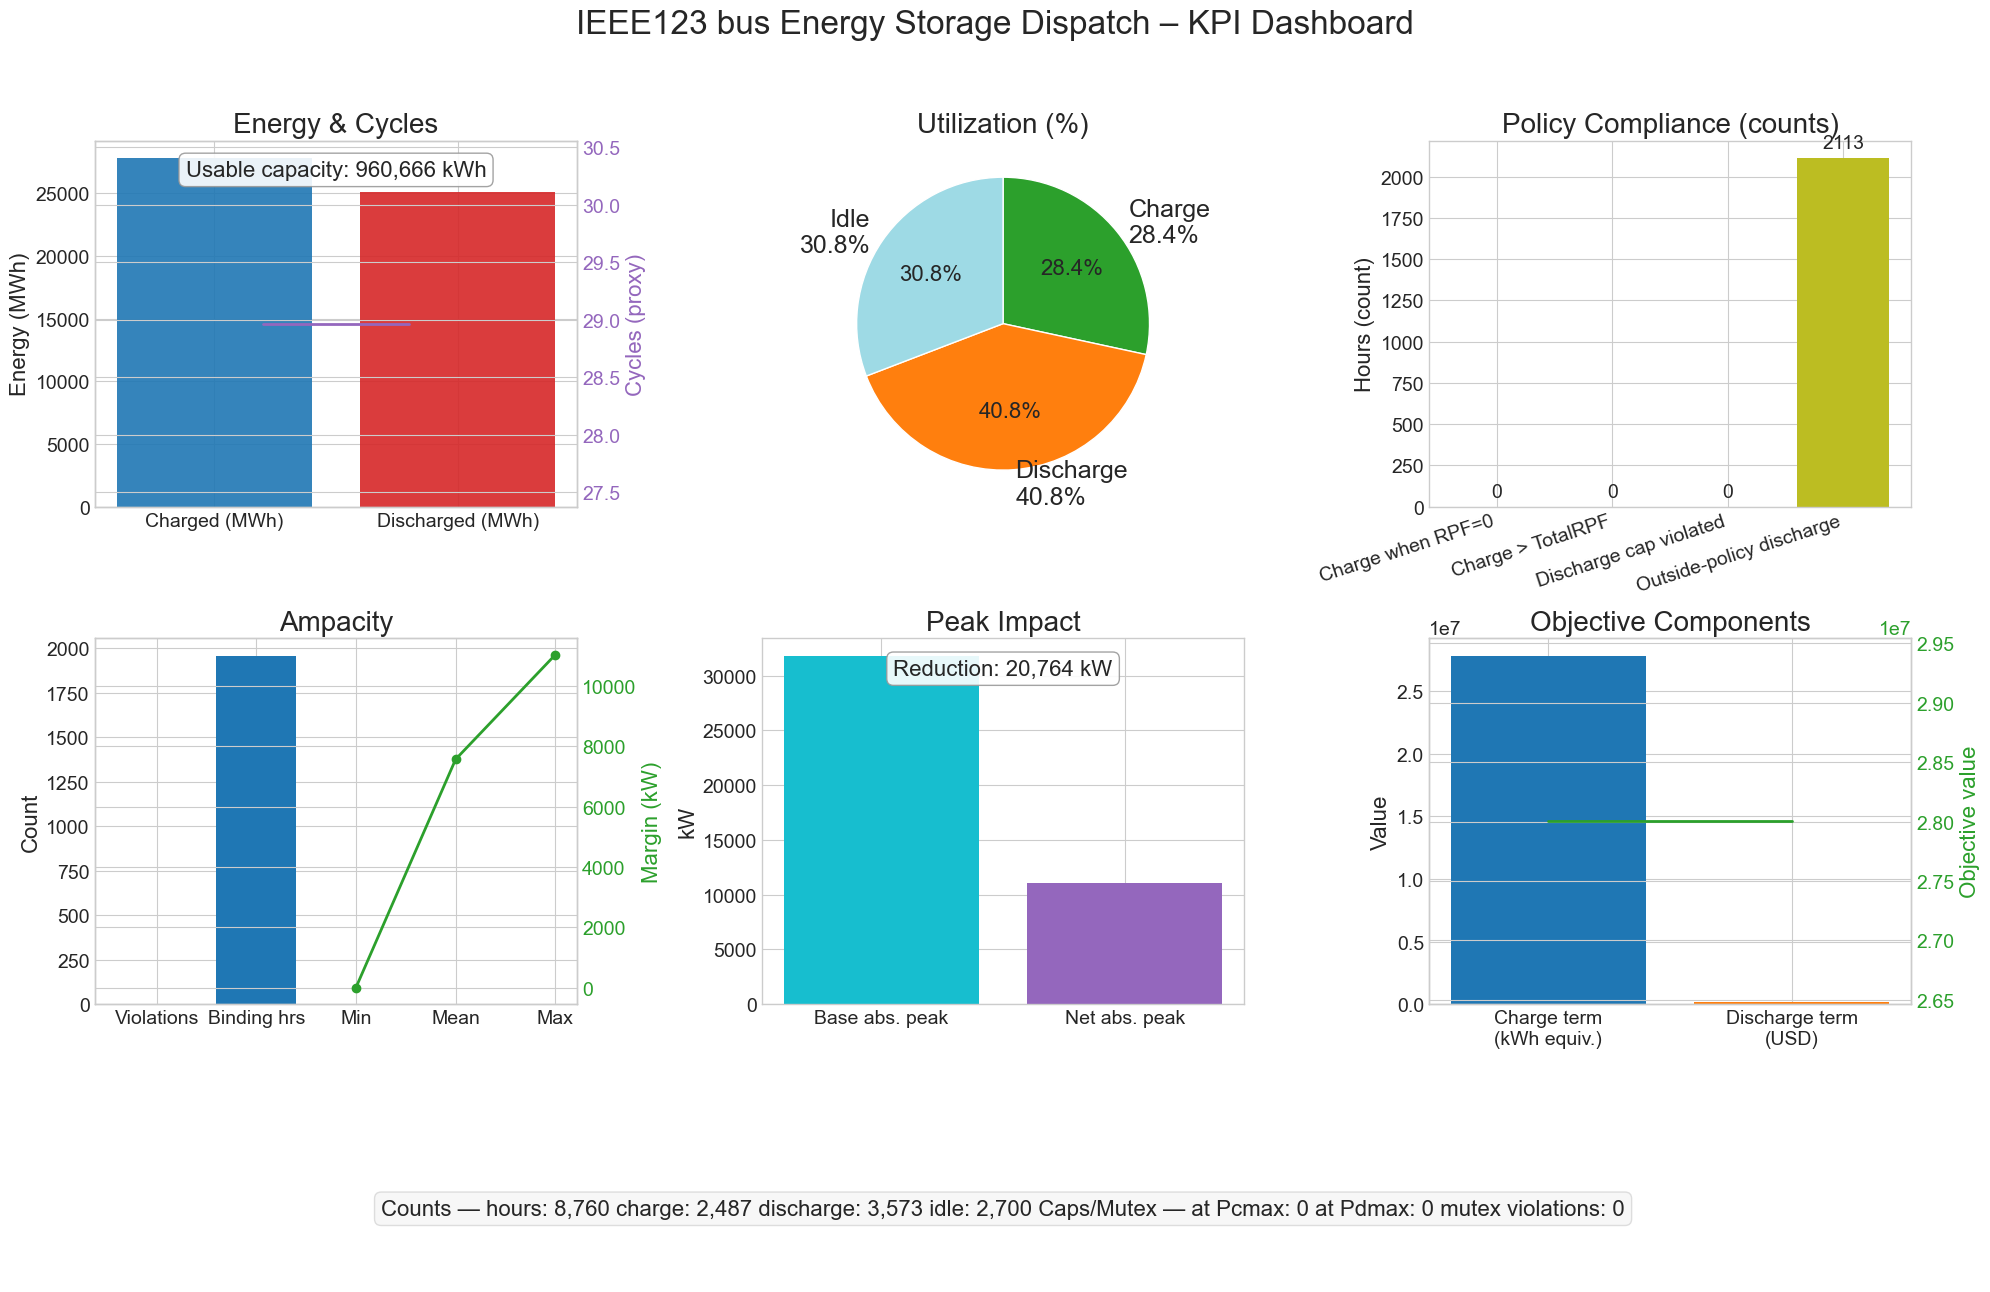

In [21]:
"""
KPI Dashboard (uniform large fonts across all panels, including pie chart)
- Reads 'KPIs_summary.json' produced by KPI script (works with true JSON or flattened text)
- Produces a multi-panel figure with consistent, presentation-ready typography
Adjust font sizes in the section: "GLOBAL FONT SIZES"
"""
import json
import re
from pathlib import Path
from typing import Dict, Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
# ==============================
# User parameters
# ==============================
kpi_path = Path("KPIs_summary.json")
fig_path_png = Path("KPI_Dashboard_UniformFonts.png")
fig_path_pdf = Path("KPI_Dashboard_UniformFonts.pdf")
# ==============================
# GLOBAL FONT SIZES (edit here)
# ==============================
SUptitle_FS = 24 # figure title
Title_FS = 20    # individual panel titles
Label_FS = 16    # axis labels
Tick_FS = 14     # tick labels
Annot_FS = 16    # annotations (badges, callouts, footer)
PieLabel_FS = 18 # pie chart slice labels (Charge/Discharge/Idle)
PiePct_FS = 16   # pie chart percentages
# Optional: set rcParams for a consistent baseline
plt.rcParams.update({
    "axes.titlesize": Title_FS,
    "axes.labelsize": Label_FS,
    "xtick.labelsize": Tick_FS,
    "ytick.labelsize": Tick_FS,
    "legend.fontsize": Label_FS,
})
# ==============================
# Loader that accepts JSON or flattened text
# ==============================
def load_kpis_loose(p: Path) -> Dict[str, Any]:
    txt = p.read_text(encoding="utf-8").strip()
    # Try strict JSON first
    try:
        return json.loads(txt)
    except Exception:
        pass
    # Fallback: parse flattened space-separated pairs
    tokens = txt.replace("\n", " ").split()
    sections = {
        "objective_terms": {},
        "energy": {"SoC_stats": {}},
        "policy_compliance": {"violations": {}},
        "ampacity": {"margin_stats_kW": {}},
        "caps_and_mutex": {},
        "utilization_percent": {},
        "peak_impact": {},
        "counts": {},
    }
    sec_names = list(sections.keys())
    idxs = []
    for s in sec_names:
        try:
            idxs.append((s, tokens.index(s)))
        except ValueError:
            pass
    idxs.sort(key=lambda x: x[1])
    idxs.append(("__END__", len(tokens)))
    nested_targets = {
        # policy violations
        "charge_when_RPF0_count": ("policy_compliance", "violations"),
        "charge_exceed_TotalRPF_count": ("policy_compliance", "violations"),
        "discharge_cap_active_violations_count": ("policy_compliance", "violations"),
        # ampacity margin stats
        "margin_min_kW": ("ampacity", "margin_stats_kW"),
        "margin_mean_kW": ("ampacity", "margin_stats_kW"),
        "margin_max_kW": ("ampacity", "margin_stats_kW"),
        # SoC stats
        "E_kWh_min": ("energy", "SoC_stats"),
        "E_kWh_max": ("energy", "SoC_stats"),
        "E_kWh_mean": ("energy", "SoC_stats"),
        "E_kWh_std": ("energy", "SoC_stats"),
    }
    def cast_num(s: str):
        try:
            if re.match(r"^\-?\d+$", s):
                return int(s)
            return float(s.replace(",", ""))
        except Exception:
            return s
    for i in range(len(idxs)-1):
        sname, start = idxs[i]
        _, end = idxs[i+1]
        if sname == "__END__":
            continue
        cursor = start + 1
        while cursor < end:
            key = tokens[cursor]
            if key in ("SoC_stats", "violations", "margin_stats_kW"):
                cursor += 1
                continue
            if cursor + 1 >= end:
                break
            val = tokens[cursor + 1]
            value = cast_num(val)
            if key in nested_targets:
                top, sub = nested_targets[key]
                sections[top][sub][key] = value
            else:
                if sname not in sections:
                    sections[sname] = {}
                sections[sname][key] = value
            cursor += 2
    return sections
# ==============================
# Load KPIs
# ==============================
kpis = load_kpis_loose(kpi_path)
obj  = kpis.get("objective_terms", {})
eng  = kpis.get("energy", {})
soc  = eng.get("SoC_stats", {})
pol  = kpis.get("policy_compliance", {})
viol = pol.get("violations", {})
amp  = kpis.get("ampacity", {})
amp_m= amp.get("margin_stats_kW", {})
cap  = kpis.get("caps_and_mutex", {})
util = kpis.get("utilization_percent", {})
peak = kpis.get("peak_impact", {})
cnt  = kpis.get("counts", {})
# ==============================
# Build figure & axes
# ==============================
plt.style.use("seaborn-v0_8-whitegrid")
fig = plt.figure(figsize=(20, 14))
# Make footer row smaller so it's closer to main panels
gs = gridspec.GridSpec(
    3, 3, figure=fig,
    height_ratios=[1.0, 1.0, 0.4],
    width_ratios=[1.1, 1.1, 1.1]
)
ax_energy = fig.add_subplot(gs[0, 0])
ax_util   = fig.add_subplot(gs[0, 1])
ax_policy = fig.add_subplot(gs[0, 2])
ax_amp    = fig.add_subplot(gs[1, 0])
ax_peak   = fig.add_subplot(gs[1, 1])
ax_obj    = fig.add_subplot(gs[1, 2])
ax_counts = fig.add_subplot(gs[2, :])
fig.suptitle("IEEE123 bus Energy Storage Dispatch – KPI Dashboard", fontsize=SUptitle_FS, y=0.97)
# ==============================
# Panel A: Energy flows
# ==============================
charged    = eng.get("E_charged_MWh", np.nan)
discharged = eng.get("E_discharged_MWh", np.nan)
usable_cap = eng.get("usable_capacity_kWh", np.nan)
cycles_proxy = eng.get("cycles_proxy", np.nan)
ax_energy.bar(["Charged (MWh)", "Discharged (MWh)"], [charged, discharged],
              color=["#1f77b4", "#d62728"], alpha=0.9)
ax_energy.set_ylabel("Energy (MWh)", fontsize=Label_FS)
ax_energy.set_title("Energy & Cycles", fontsize=Title_FS)
ax_energy.tick_params(axis='both', labelsize=Tick_FS)
ax_energy2 = ax_energy.twinx()
ax_energy2.plot([0.2, 0.8], [cycles_proxy, cycles_proxy], color="#9467bd", lw=2)
ax_energy2.set_ylabel("Cycles (proxy)", color="#9467bd", fontsize=Label_FS)
ax_energy2.tick_params(axis='y', colors="#9467bd", labelsize=Tick_FS)
ax_energy.text(
    0.5, 0.92, f"Usable capacity: {usable_cap:,.0f} kWh",
    transform=ax_energy.transAxes, ha="center", va="center",
    bbox=dict(boxstyle="round", fc="white", ec="#999", alpha=0.9),
    fontsize=Annot_FS
)
# ==============================
# Panel B: Utilization (Pie) – with explicit larger label & pct fonts
# ==============================
pct_c = util.get("pct_charge", 0.0)
pct_d = util.get("pct_discharge", 0.0)
pct_i = util.get("pct_idle", 0.0)
def _autopct(pct):
    # Just percentages; the label text already carries the state
    return f"{pct:.1f}%"
wedges, texts, autotexts = ax_util.pie(
    [pct_c, pct_d, pct_i],
    labels=[f"Charge\n{pct_c:.1f}%", f"Discharge\n{pct_d:.1f}%", f"Idle\n{pct_i:.1f}%"],
    colors=["#2ca02c", "#ff7f0e", "#9edae5"],
    autopct=_autopct,
    startangle=90,
    counterclock=False,
    wedgeprops=dict(edgecolor="white")
)
# Apply font sizes explicitly to pie labels & percentages
for t in texts:      # labels on wedges
    t.set_fontsize(PieLabel_FS)
for t in autotexts:  # autopct percentages
    t.set_fontsize(PiePct_FS)
ax_util.set_title("Utilization (%)", fontsize=Title_FS)
# ==============================
# Panel C: Policy compliance  (FIXED labeling to match correct columns)
# ==============================
# Canonical definition: data source key -> (label, color, source_dict)
# - "viol" entries live under kpis["policy_compliance"]["violations"]
# - "pol"  entries live directly under kpis["policy_compliance"]
policy_items = [
    ("charge_when_RPF0_count",                "Charge when RPF=0",        "#8c564b", viol),
    ("charge_exceed_TotalRPF_count",          "Charge > TotalRPF",        "#e377c2", viol),
    ("discharge_cap_active_violations_count", "Discharge cap violated",   "#7f7f7f", viol),
    ("outside_policy_discharge_info_count",   "Outside-policy discharge", "#bcbd22", pol),
]
# Build arrays in a fixed order so ticks always match bars
labels = [lbl for _, lbl, _, _ in policy_items]
colors = [c for _, _, c, _ in policy_items]
values = []
for key, _, _, src in policy_items:
    # Coerce to int in case the loose loader returns strings/floats
    values.append(int(src.get(key, 0) or 0))
# Plot by numeric positions, then set tick labels explicitly
x = np.arange(len(labels))
bars = ax_policy.bar(x, values, color=colors)
ax_policy.set_ylabel("Hours (count)", fontsize=Label_FS)
ax_policy.set_title("Policy Compliance (counts)", fontsize=Title_FS)
ax_policy.set_xticks(x)
ax_policy.set_xticklabels(labels, rotation=18, ha="right")
ax_policy.tick_params(axis="y", labelsize=Tick_FS)
ax_policy.tick_params(axis="x", labelsize=Tick_FS)
# Optional: annotate counts above bars for clarity (safe even when zero)
for rect, val in zip(bars, values):
    ax_policy.annotate(f"{val}",
                       xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                       xytext=(0, 4),
                       textcoords="offset points",
                       ha="center", va="bottom",
                       fontsize=Tick_FS)
# ==============================
# Panel D: Ampacity diagnostics
# ==============================
viol_count = amp.get("violations_count", 0)
bind_count = amp.get("binding_hours_count", 0)
m_min = amp_m.get("margin_min_kW", np.nan)
m_mean = amp_m.get("margin_mean_kW", np.nan)
m_max = amp_m.get("margin_max_kW", np.nan)
ax_amp.bar(["Violations", "Binding hrs"], [viol_count, bind_count],
           color=["#d62728", "#1f77b4"])
ax_amp.set_ylabel("Count", fontsize=Label_FS)
ax_amp.set_title("Ampacity", fontsize=Title_FS)
ax_amp.tick_params(axis='both', labelsize=Tick_FS)
ax_amp2 = ax_amp.twinx()
ax_amp2.plot(["Min", "Mean", "Max"], [m_min, m_mean, m_max],
             marker="o", color="#2ca02c", lw=2)
ax_amp2.set_ylabel("Margin (kW)", color="#2ca02c", fontsize=Label_FS)
ax_amp2.tick_params(axis='y', colors="#2ca02c", labelsize=Tick_FS)
# ==============================
# Panel E: Peak impact
# ==============================
base_peak = peak.get("base_abs_peak_kW", np.nan)
net_peak  = peak.get("net_abs_peak_kW", np.nan)
peak_red  = peak.get("peak_reduction_kW", np.nan)
ax_peak.bar(["Base abs. peak", "Net abs. peak"], [base_peak, net_peak],
            color=["#17becf", "#9467bd"])
ax_peak.set_ylabel("kW", fontsize=Label_FS)
ax_peak.set_title("Peak Impact", fontsize=Title_FS)
ax_peak.tick_params(axis='both', labelsize=Tick_FS)
ax_peak.text(
    0.5, 0.9, f"Reduction: {peak_red:,.0f} kW",
    transform=ax_peak.transAxes, ha="center",
    bbox=dict(boxstyle="round", fc="white", ec="#999", alpha=0.9),
    fontsize=Annot_FS
)
# ==============================
# Panel F: Objective terms
# ==============================
term_ch = obj.get("term_charge_sum_kWh_equiv", np.nan)
term_d  = obj.get("term_discharge_sum_USD", np.nan)
obj_val = obj.get("objective_value", np.nan)
ax_obj.bar(["Charge term\n(kWh equiv.)", "Discharge term\n(USD)"], [term_ch, term_d],
           color=["#1f77b4", "#ff7f0e"])
ax_obj.set_ylabel("Value", fontsize=Label_FS)
ax_obj.set_title("Objective Components", fontsize=Title_FS)
ax_obj.tick_params(axis='both', labelsize=Tick_FS)
ax_obj2 = ax_obj.twinx()
ax_obj2.plot([0, 1], [obj_val, obj_val], color="#2ca02c", lw=2)
ax_obj2.set_ylabel("Objective value", color="#2ca02c", fontsize=Label_FS)
ax_obj2.tick_params(axis='y', colors="#2ca02c", labelsize=Tick_FS)
# ==============================
# Footer (counts + caps/mutex)
# ==============================
ax_counts.axis("off")
footer_text = (
    f"Counts — hours: {int(cnt.get('n_hours', 0)):,} "
    f"charge: {int(cnt.get('n_charge_hours', 0)):,} "
    f"discharge: {int(cnt.get('n_discharge_hours', 0)):,} "
    f"idle: {int(cnt.get('n_idle_hours', 0)):,} "
    f"Caps/Mutex — at Pcmax: {int(cap.get('at_Pcmax_hours', 0))} "
    f"at Pdmax: {int(cap.get('at_Pdmax_hours', 0))} "
    f"mutex violations: {int(cap.get('mutex_violations_count', 0))}"
)
ax_counts.text(
    0.5, 0.5, footer_text, ha="center", va="center",
    bbox=dict(boxstyle="round", fc="#f7f7f7", ec="#ddd"),
    fontsize=Annot_FS
)
# Tight layout with slightly reduced bottom/top margins (brings footer closer)
plt.tight_layout(rect=[0, 0.05, 1, 0.94])
fig.savefig(fig_path_png, dpi=220)
fig.savefig(fig_path_pdf)
print(f"Saved KPI dashboard with uniform fonts to:\n - {fig_path_png.resolve()}\n - {fig_path_pdf.resolve()}")


#### Presentation plots 

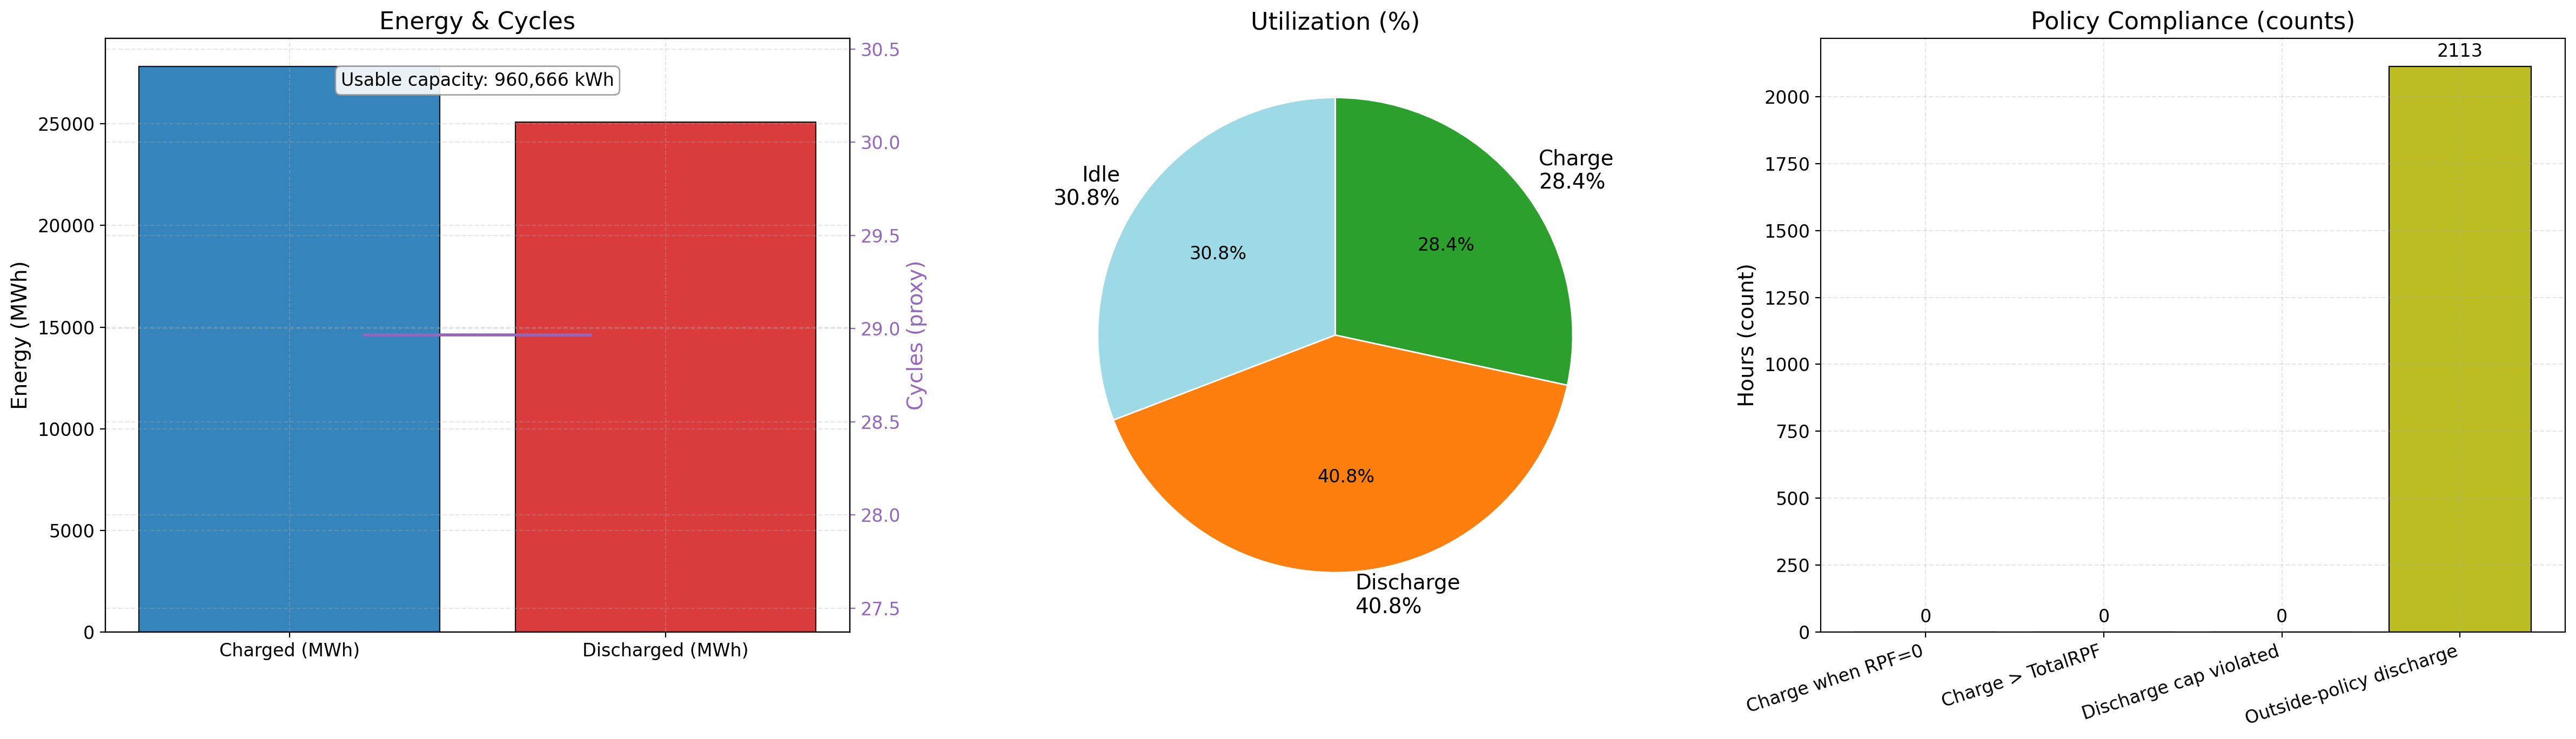

Saved 1×3 figure to:
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_row1_three_panels.png
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_row1_three_panels.pdf


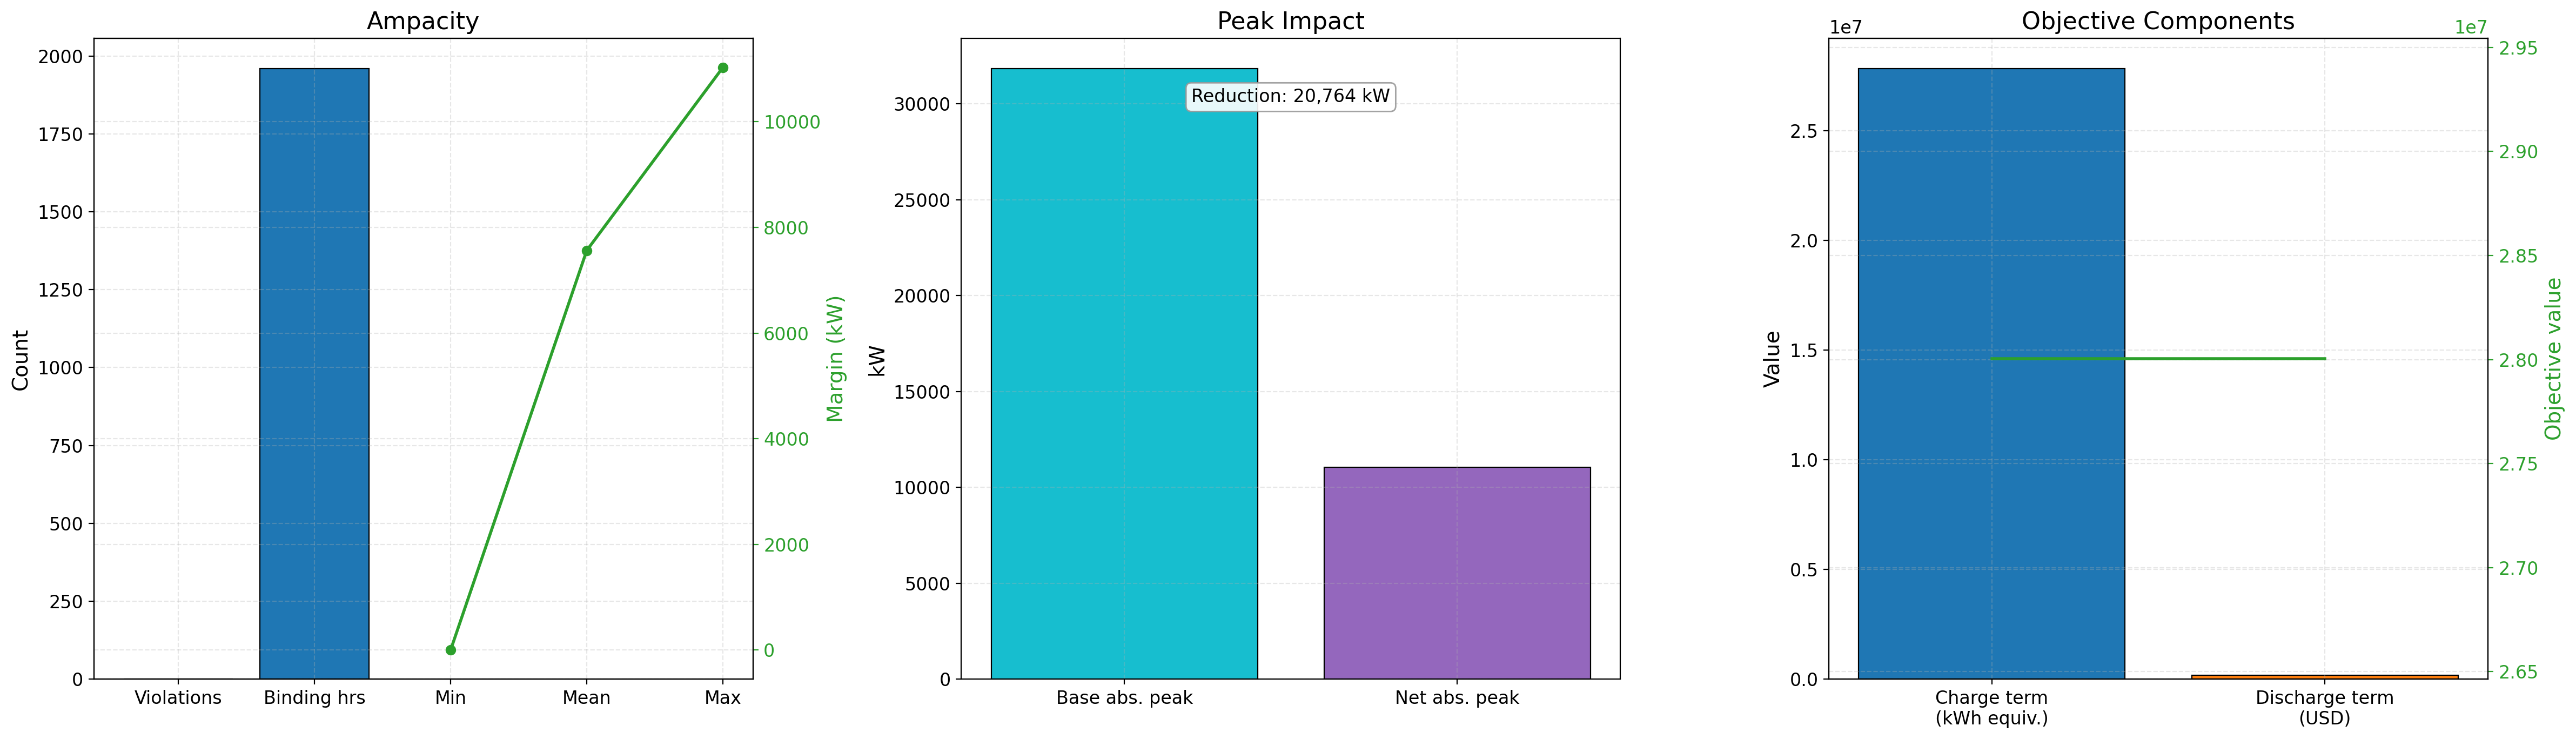

Saved 1×3 figure to:
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_row2_three_panels.png
 - C:\Users\UCHENONU\GitFile_RPF\IEEE123\KPI_row2_three_panels.pdf


In [5]:

# kpi_rows_separate_figures.py
import json
import re
from pathlib import Path
from typing import Dict, Any, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ==============================
# Presentation: legible fonts & high resolution
# ==============================
mpl.rcParams['figure.dpi']   = 200           # on-screen clarity
mpl.rcParams['savefig.dpi']  = 300           # export clarity (print-quality)
mpl.rcParams['font.family']  = 'DejaVu Sans' # use 'Arial' if available/preferred
mpl.rcParams['font.size']    = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 0.3

# ==============================
# User parameters
# ==============================
kpi_path = Path("KPIs_summary.json")
out_row1_png  = Path("KPI_row1_three_panels.png")
out_row1_pdf  = Path("KPI_row1_three_panels.pdf")
out_row2_png  = Path("KPI_row2_three_panels.png")
out_row2_pdf  = Path("KPI_row2_three_panels.pdf")

# Row definitions (exactly match the original dashboard rows)
ROW1: Tuple[str, str, str] = ("Energy & Cycles", "Utilization (%)", "Policy Compliance (counts)")
ROW2: Tuple[str, str, str] = ("Ampacity", "Peak Impact", "Objective Components")

# ==============================
# Loader (compatible with kpiori.txt)
# ==============================
def load_kpis_loose(p: Path) -> Dict[str, Any]:
    txt = p.read_text(encoding="utf-8").strip()
    # Try strict JSON first
    try:
        return json.loads(txt)
    except Exception:
        pass

    # Fallback: parse flattened space-separated pairs (mirrors kpiori logic)
    tokens = txt.replace("\n", " ").split()
    sections = {
        "objective_terms": {},
        "energy": {"SoC_stats": {}},
        "policy_compliance": {"violations": {}},
        "ampacity": {"margin_stats_kW": {}},
        "caps_and_mutex": {},
        "utilization_percent": {},
        "peak_impact": {},
        "counts": {},
    }
    sec_names = list(sections.keys())
    idxs = []
    for s in sec_names:
        try:
            idxs.append((s, tokens.index(s)))
        except ValueError:
            pass
    idxs.sort(key=lambda x: x[1])
    idxs.append(("__END__", len(tokens)))

    nested_targets = {
        # policy violations
        "charge_when_RPF0_count": ("policy_compliance", "violations"),
        "charge_exceed_TotalRPF_count": ("policy_compliance", "violations"),
        "discharge_cap_active_violations_count": ("policy_compliance", "violations"),
        # ampacity margin stats
        "margin_min_kW": ("ampacity", "margin_stats_kW"),
        "margin_mean_kW": ("ampacity", "margin_stats_kW"),
        "margin_max_kW": ("ampacity", "margin_stats_kW"),
        # SoC stats
        "E_kWh_min": ("energy", "SoC_stats"),
        "E_kWh_max": ("energy", "SoC_stats"),
        "E_kWh_mean": ("energy", "SoC_stats"),
        "E_kWh_std": ("energy", "SoC_stats"),
    }
    def cast_num(s: str):
        try:
            if re.match(r"^-?\d+$", s):
                return int(s)
            return float(s.replace(",", ""))
        except Exception:
            return s

    for i in range(len(idxs) - 1):
        sname, start = idxs[i]
        _, end = idxs[i + 1]
        if sname == "__END__":
            continue
        cursor = start + 1
        while cursor < end:
            key = tokens[cursor]
            if key in ("SoC_stats", "violations", "margin_stats_kW"):
                cursor += 1
                continue
            if cursor + 1 >= end:
                break
            val = tokens[cursor + 1]
            value = cast_num(val)
            if key in nested_targets:
                top, sub = nested_targets[key]
                sections[top][sub][key] = value
            else:
                if sname not in sections:
                    sections[sname] = {}
                sections[sname][key] = value
            cursor += 2
    return sections

# ==============================
# Panel builders (same visuals as dashboard)
# ==============================
def panel_energy(ax, eng: Dict[str, Any]):
    charged     = eng.get("E_charged_MWh", np.nan)
    discharged  = eng.get("E_discharged_MWh", np.nan)
    usable_cap  = eng.get("usable_capacity_kWh", np.nan)
    cycles_proxy= eng.get("cycles_proxy", np.nan)

    ax.bar(["Charged (MWh)", "Discharged (MWh)"], [charged, discharged],
           color=["#1f77b4", "#d62728"], alpha=0.9, edgecolor='black', linewidth=0.8)
    ax.set_title("Energy & Cycles")
    ax.set_ylabel("Energy (MWh)")
    ax.grid(True, axis='y')

    # Usable capacity callout
    ax.text(0.5, 0.92, f"Usable capacity: {usable_cap:,.0f} kWh",
            transform=ax.transAxes, ha="center",
            bbox=dict(boxstyle="round", fc="white", ec="#999", alpha=0.9))

    # Cycles proxy on twin axis
    ax2 = ax.twinx()
    ax2.plot([0.2, 0.8], [cycles_proxy, cycles_proxy], color="#9467bd", lw=2)
    ax2.set_ylabel("Cycles (proxy)", color="#9467bd")
    ax2.tick_params(axis='y', colors="#9467bd")

def panel_utilization(ax, util: Dict[str, Any]):
    pct_c = util.get("pct_charge", 0.0)
    pct_d = util.get("pct_discharge", 0.0)
    pct_i = util.get("pct_idle", 0.0)

    wedges, texts, autotexts = ax.pie(
        [pct_c, pct_d, pct_i],
        labels=[f"Charge\n{pct_c:.1f}%", f"Discharge\n{pct_d:.1f}%", f"Idle\n{pct_i:.1f}%"],
        colors=["#2ca02c", "#ff7f0e", "#9edae5"],
        autopct=lambda p: f"{p:.1f}%",
        startangle=90, counterclock=False,
        wedgeprops=dict(edgecolor="white")
    )
    ax.set_title("Utilization (%)")
    for t in texts: t.set_fontsize(14)
    for t in autotexts: t.set_fontsize(12)

def panel_policy(ax, pol: Dict[str, Any], viol: Dict[str, Any]):
    items = [
        ("charge_when_RPF0_count", "Charge when RPF=0",           "#8c564b", viol),
        ("charge_exceed_TotalRPF_count", "Charge > TotalRPF",      "#e377c2", viol),
        ("discharge_cap_active_violations_count", "Discharge cap violated", "#7f7f7f", viol),
        ("outside_policy_discharge_info_count", "Outside-policy discharge", "#bcbd22", pol),
    ]
    labels = [lbl for _, lbl, _, _ in items]
    colors = [c for _, _, c, _ in items]
    values = [int(src.get(key, 0) or 0) for key, _, _, src in items]

    x = np.arange(len(labels))
    bars = ax.bar(x, values, color=colors, edgecolor='black', linewidth=0.8)
    ax.set_title("Policy Compliance (counts)")
    ax.set_ylabel("Hours (count)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=18, ha="right")
    ax.grid(True, axis='y')

    # annotate counts above bars
    for rect, val in zip(bars, values):
        ax.annotate(f"{val}",
                    xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
                    xytext=(0, 4), textcoords="offset points",
                    ha="center", va="bottom")

def panel_ampacity(ax, amp: Dict[str, Any], amp_m: Dict[str, Any]):
    viol_count = amp.get("violations_count", 0)
    bind_count = amp.get("binding_hours_count", 0)
    m_min = amp_m.get("margin_min_kW", np.nan)
    m_mean = amp_m.get("margin_mean_kW", np.nan)
    m_max = amp_m.get("margin_max_kW", np.nan)

    ax.bar(["Violations", "Binding hrs"], [viol_count, bind_count],
           color=["#d62728", "#1f77b4"], edgecolor='black', linewidth=0.8)
    ax.set_title("Ampacity")
    ax.set_ylabel("Count")
    ax.grid(True, axis='y')

    ax2 = ax.twinx()
    ax2.plot(["Min", "Mean", "Max"], [m_min, m_mean, m_max],
             marker="o", color="#2ca02c", lw=2)
    ax2.set_ylabel("Margin (kW)", color="#2ca02c")
    ax2.tick_params(axis='y', colors="#2ca02c")

def panel_peak(ax, peak: Dict[str, Any]):
    base_peak = peak.get("base_abs_peak_kW", np.nan)
    net_peak  = peak.get("net_abs_peak_kW", np.nan)
    peak_red  = peak.get("peak_reduction_kW", np.nan)

    ax.bar(["Base abs. peak", "Net abs. peak"], [base_peak, net_peak],
           color=["#17becf", "#9467bd"], edgecolor='black', linewidth=0.8)
    ax.set_title("Peak Impact")
    ax.set_ylabel("kW")
    ax.grid(True, axis='y')
    ax.text(0.5, 0.9, f"Reduction: {peak_red:,.0f} kW",
            transform=ax.transAxes, ha="center",
            bbox=dict(boxstyle="round", fc="white", ec="#999", alpha=0.9))

def panel_objective(ax, obj: Dict[str, Any]):
    term_ch = obj.get("term_charge_sum_kWh_equiv", np.nan)
    term_d  = obj.get("term_discharge_sum_USD", np.nan)
    obj_val = obj.get("objective_value", np.nan)

    ax.bar(["Charge term\n(kWh equiv.)", "Discharge term\n(USD)"], [term_ch, term_d],
           color=["#1f77b4", "#ff7f0e"], edgecolor='black', linewidth=0.8)
    ax.set_title("Objective Components")
    ax.set_ylabel("Value")
    ax.grid(True, axis='y')

    ax2 = ax.twinx()
    ax2.plot([0, 1], [obj_val, obj_val], color="#2ca02c", lw=2)
    ax2.set_ylabel("Objective value", color="#2ca02c")
    ax2.tick_params(axis='y', colors="#2ca02c")

# ==============================
# Helper to render one 1×3 figure from a tuple of panel names
# ==============================
def render_row(panel_names: Tuple[str, str, str], out_png: Path, out_pdf: Path, kpis: Dict[str, Any]):
    eng   = kpis.get("energy", {})
    util  = kpis.get("utilization_percent", {})
    pol   = kpis.get("policy_compliance", {})
    viol  = pol.get("violations", {})
    amp   = kpis.get("ampacity", {})
    amp_m = amp.get("margin_stats_kW", {})
    peak  = kpis.get("peak_impact", {})
    obj   = kpis.get("objective_terms", {})

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))

    for idx, name in enumerate(panel_names):
        ax = axes[idx]
        if name == "Energy & Cycles":
            panel_energy(ax, eng)
        elif name == "Utilization (%)":
            panel_utilization(ax, util)
        elif name == "Policy Compliance (counts)":
            panel_policy(ax, pol, viol)
        elif name == "Ampacity":
            panel_ampacity(ax, amp, amp_m)
        elif name == "Peak Impact":
            panel_peak(ax, peak)
        elif name == "Objective Components":
            panel_objective(ax, obj)
        else:
            ax.text(0.5, 0.5, f"Unknown panel:\n{name}", ha="center", va="center",
                    bbox=dict(boxstyle="round", fc="#f7f7f7", ec="#ddd"))
            ax.set_axis_off()

    plt.tight_layout()
    fig.savefig(out_png, bbox_inches='tight')
    fig.savefig(out_pdf)
    plt.show()
    print(f"Saved 1×3 figure to:\n - {out_png.resolve()}\n - {out_pdf.resolve()}")

# ==============================
# Main
# ==============================
if __name__ == "__main__":
    kpis = load_kpis_loose(kpi_path)
    # Row 1 (Energy, Utilization, Policy)
    render_row(ROW1, out_row1_png, out_row1_pdf, kpis)
    # Row 2 (Ampacity, Peak, Objective)
    render_row(ROW2, out_row2_png, out_row2_pdf, kpis)


### plot_ampacity_envelope

[Saved] ampacity_plots\ampacity_envelope_row0010.png


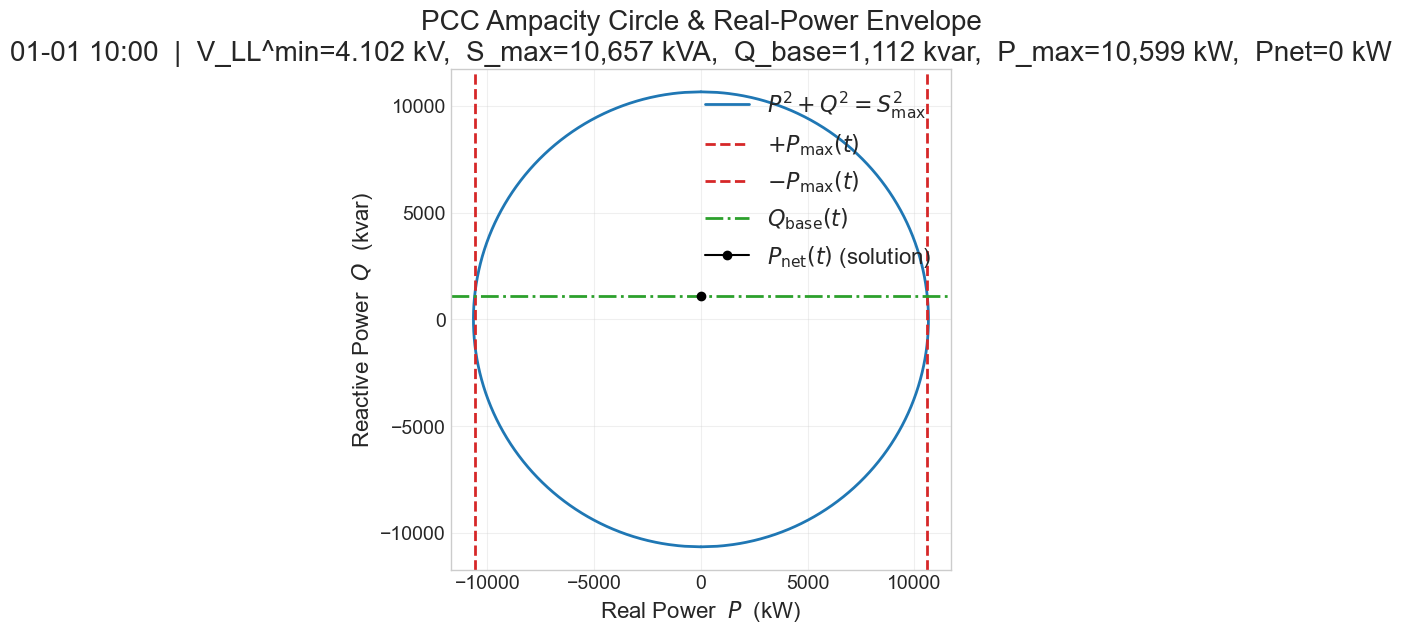

[Saved] ampacity_plots\ampacity_envelope_row0100.png


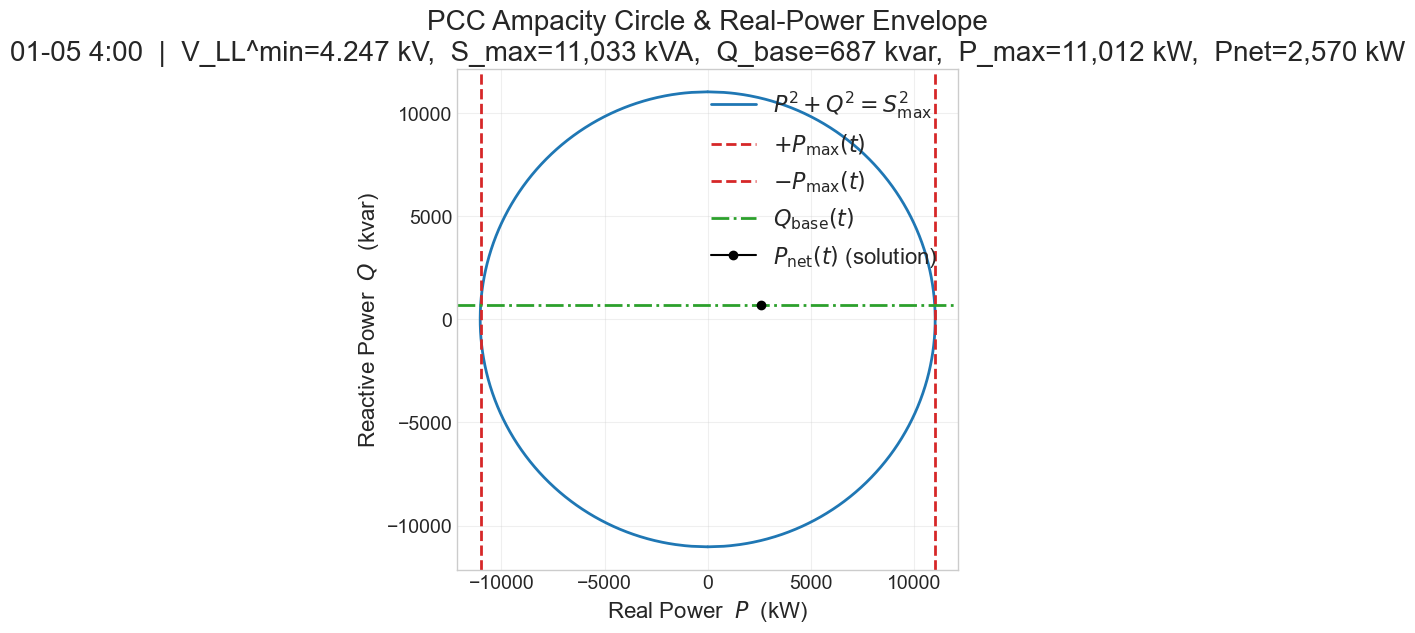


Top-N tightest hours (smallest envelope margin):
 row_idx     margin_kW      Pmax_kW  P_target_kW
    3413 -1.455192e-11 10755.268008 10755.268008
    5335 -1.273293e-11 10825.829790 10825.829790
    4806 -1.091394e-11 10710.896831 10710.896831
[Saved] ampacity_plots\ampacity_envelope_row3413.png


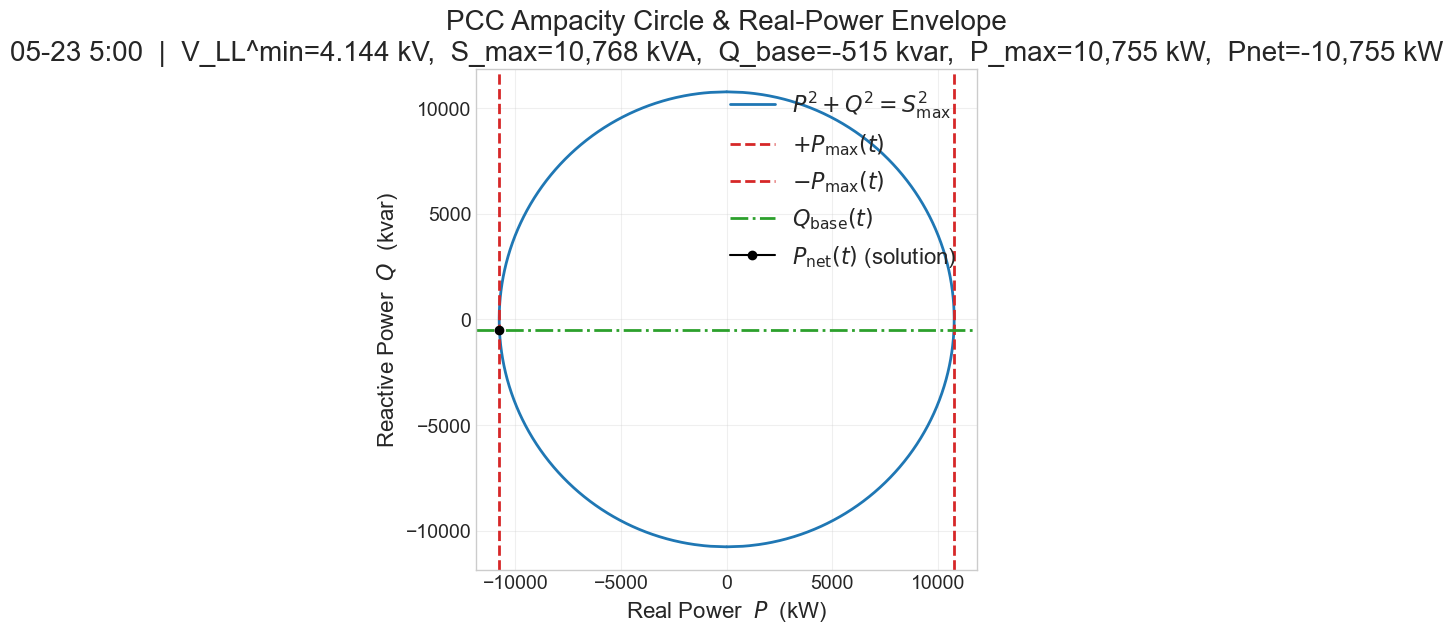

[Saved] ampacity_plots\ampacity_envelope_row5335.png


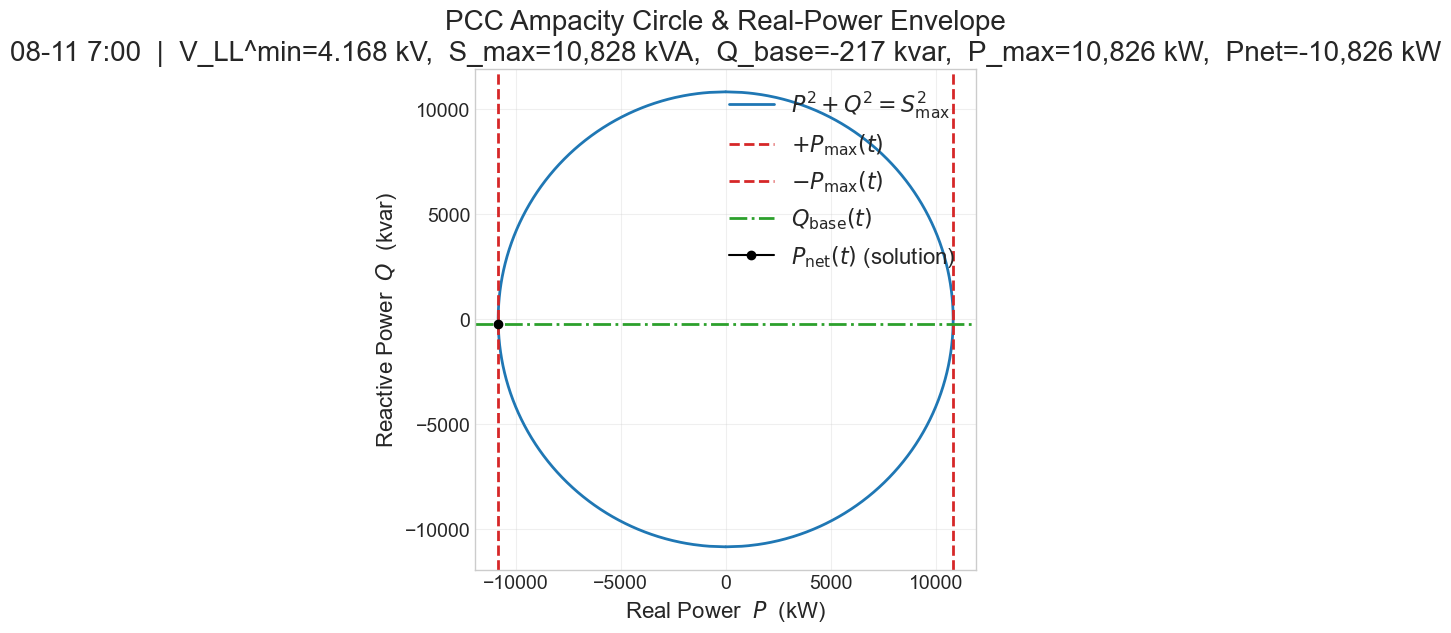

[Saved] ampacity_plots\ampacity_envelope_row4806.png


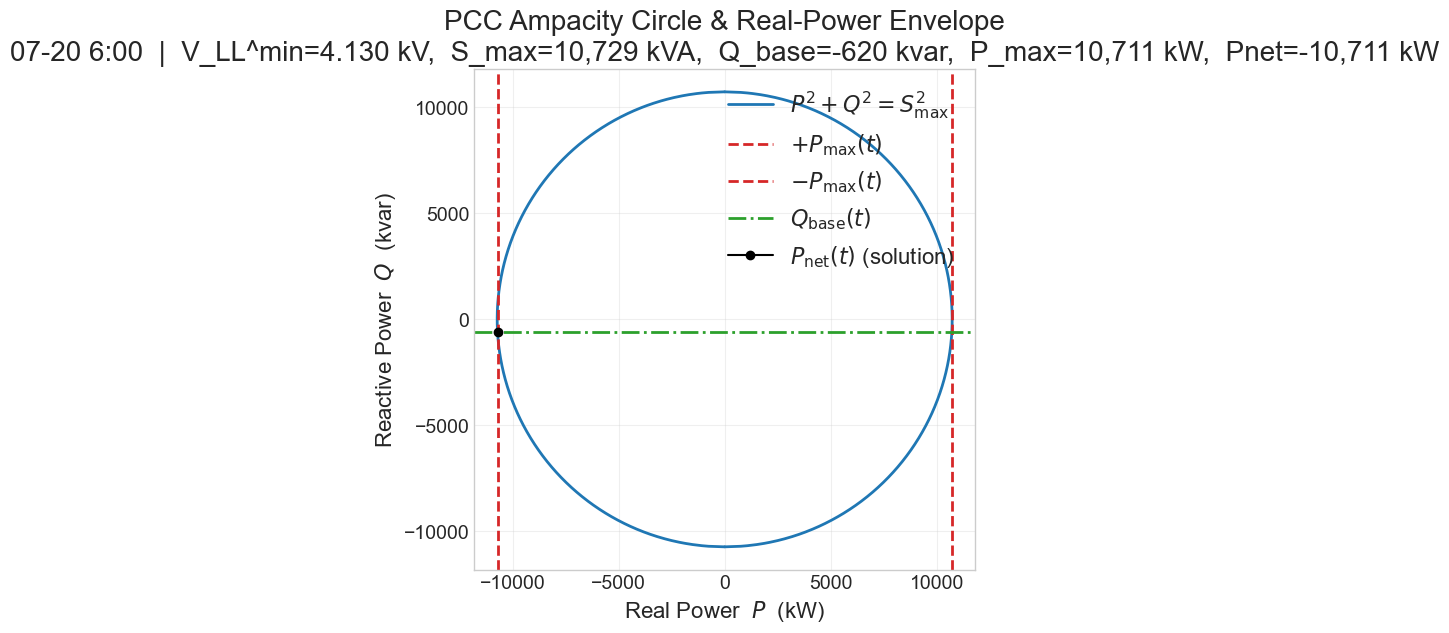

In [24]:
# plot_ampacity_envelope.py
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ USER PARAMS ------------------
DATA_CSV = "IEEE123Storage_Dispatch_with_cost.csv"               # input dataset
SOLUTION_CSV = "IEEE123Storage_Dispatch_solution_gurobi.csv"     # optional (for overlay), set None if not available

VLL_NOM_KV = 4.16        # PCC nominal line-to-line voltage (kV)
IMAX_A     = 1500.0      # PCC ampacity (A)
PU_FLOOR   = None        # Optional conservative voltage floor in pu (e.g., 0.98). If None, use measured min(V1,V2,V3).

# Figure save options
OUT_DIR = "ampacity_plots"
SAVE_PNG = True
DPI = 200

# How to select which hour(s) to plot
SELECT_BY_INDEX = [10, 100]        # list of integer row indices to plot (0-based). Ignored if empty and SELECT_BY_TIME is used.
SELECT_BY_TIME  = []               # list of strings matching df['Time_stamp'] (e.g., ["01-01 10:00"]). Ignored if empty.
TOP_N_TIGHTEST  = 3                # additionally plot the N hours with smallest (P_max - |P_net|) or (P_max - |P_base|) if no solution. Set 0 to skip.
# ------------------------------------------------


def compute_VLL_min_kV(row, vll_nom_kV, pu_floor=None):
    """
    Conservative lower bound on line-to-line voltage for one hour.
    If pu_floor is provided, use VLL_min = vll_nom_kV * pu_floor.
    Otherwise, compute from measured per-phase pu: VLL_min = VLL_nom * min(V1, V2, V3).
    """
    if pu_floor is not None:
        return vll_nom_kV * float(pu_floor)
    v1, v2, v3 = float(row["V1"]), float(row["V2"]), float(row["V3"])
    return vll_nom_kV * min(v1, v2, v3)


def compute_Smax_kVA(VLL_min_kV, Imax_A):
    """ Apparent-power ampacity limit: Smax = sqrt(3) * VLL_min * Imax (kVA). """
    return math.sqrt(3.0) * VLL_min_kV * Imax_A


def compute_Pmax_kW(Smax_kVA, Q_base_kvar):
    """
    Real-power envelope radius at given Q_base:
      P_max = sqrt( max(0, Smax^2 - Q_base^2) )
    Units: S in kVA, Q in kvar, result in kW (consistent numerically).
    """
    rad2 = max(0.0, (Smax_kVA**2) - (float(Q_base_kvar)**2))
    return math.sqrt(rad2)


def ampacity_plot_for_row(df, row_idx, sol_df=None, out_dir=None, dpi=200, show=True, save_png=True):
    """
    Plot ampacity circle and ±Pmax for a single row of the dataset.
    If sol_df provided and matching row exists, overlays Pnet_kW.
    """
    if row_idx < 0 or row_idx >= len(df):
        print(f"[WARN] Row index {row_idx} is out of range [0, {len(df)-1}]")
        return
    row = df.iloc[row_idx]
    time_label = str(row.get("Time_stamp", f"t={row_idx}"))

    # Compute VLL_min, Smax, Pmax
    VLL_min_kV = compute_VLL_min_kV(row, VLL_NOM_KV, PU_FLOOR)
    Smax_kVA   = compute_Smax_kVA(VLL_min_kV, IMAX_A)
    Qb_kvar    = float(row["Q_kvar"])
    Pmax_kW    = compute_Pmax_kW(Smax_kVA, Qb_kvar)

    # Build the circle
    R = Smax_kVA
    Q_samples = np.linspace(-R, R, 800)
    P_pos = np.sqrt(np.clip(R**2 - Q_samples**2, 0.0, None))
    P_neg = -P_pos

    # Start plotting
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.plot(P_pos, Q_samples, color='C0', lw=2, label=r'$P^2 + Q^2 = S_{\max}^2$')
    ax.plot(P_neg, Q_samples, color='C0', lw=2)

    # Vertical envelope at ±Pmax for the dataset's Q_base
    ax.axvline(+Pmax_kW, color='C3', ls='--', lw=2, label=r'$+P_{\max}(t)$')
    ax.axvline(-Pmax_kW, color='C3', ls='--', lw=2, label=r'$-P_{\max}(t)$')
    ax.axhline(Qb_kvar, color='C2', ls='-.', lw=2, label=r'$Q_{\mathrm{base}}(t)$')

    # Optional overlay from solution (Pnet_kW)
    overlay_txt = ""
    if sol_df is not None and "Pnet_kW" in sol_df.columns and len(sol_df) == len(df):
        Pnet = float(sol_df.iloc[row_idx]["Pnet_kW"])
        ax.plot([Pnet], [Qb_kvar], marker='o', color='k', label=r'$P_{\mathrm{net}}(t)$ (solution)')
        overlay_txt = f",  Pnet={Pnet:,.0f} kW"

    # Cosmetics
    ax.set_aspect('equal', 'box')
    ax.grid(alpha=0.3)
    ax.set_xlabel("Real Power  $P$  (kW)")
    ax.set_ylabel("Reactive Power  $Q$  (kvar)")
    ax.set_title(
        "PCC Ampacity Circle & Real-Power Envelope\n"
        f"{time_label}  |  V_LL^min={VLL_min_kV:.3f} kV,  S_max={Smax_kVA:,.0f} kVA,  "
        f"Q_base={Qb_kvar:,.0f} kvar,  P_max={Pmax_kW:,.0f} kW{overlay_txt}"
    )
    ax.legend(loc="upper right")

    # Save
    if save_png:
        os.makedirs(out_dir or ".", exist_ok=True)
        fn = f"ampacity_envelope_row{row_idx:04d}.png"
        fp = os.path.join(out_dir or ".", fn)
        plt.savefig(fp, dpi=dpi, bbox_inches='tight')
        print(f"[Saved] {fp}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return dict(
        row_idx=row_idx,
        time=time_label,
        VLL_min_kV=VLL_min_kV,
        Smax_kVA=Smax_kVA,
        Q_base_kvar=Qb_kvar,
        Pmax_kW=Pmax_kW
    )


def rank_tightest_hours(df, sol_df=None, top_n=3):
    """
    Rank hours by how 'tight' they are relative to the envelope.
    If solution is present, use margin = Pmax - |Pnet|.
    Else, use margin = Pmax - |P_base|.
    Returns a DataFrame with columns [row_idx, margin, Pmax_kW, P_target].
    """
    rows = []
    for i, row in df.iterrows():
        VLL_min_kV = compute_VLL_min_kV(row, VLL_NOM_KV, PU_FLOOR)
        Smax_kVA   = compute_Smax_kVA(VLL_min_kV, IMAX_A)
        Pmax_kW    = compute_Pmax_kW(Smax_kVA, row["Q_kvar"])

        if sol_df is not None and "Pnet_kW" in sol_df.columns and len(sol_df) == len(df):
            target = abs(float(sol_df.iloc[i]["Pnet_kW"]))
        else:
            target = abs(float(row["P_kW"]))  # fallback: base P
        margin = Pmax_kW - target
        rows.append((i, margin, Pmax_kW, target))

    out = pd.DataFrame(rows, columns=["row_idx", "margin_kW", "Pmax_kW", "P_target_kW"])
    out = out.sort_values(by="margin_kW")  # smallest margin first
    return out.head(top_n)


def main():
    # Load dataset
    df = pd.read_csv(DATA_CSV)
    # Normalize column names exactly as in your model code
    df.columns = [c.strip().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

    # Optional solution overlay
    sol_df = None
    if SOLUTION_CSV and os.path.exists(SOLUTION_CSV):
        sol_df = pd.read_csv(SOLUTION_CSV)
        # best effort: ensure row alignment with original df
        if len(sol_df) != len(df):
            print("[WARN] Solution CSV length differs from data CSV; overlay disabled.")
            sol_df = None

    # 1) Plot by explicit selection
    selected_indices = []
    if SELECT_BY_INDEX:
        selected_indices.extend([i for i in SELECT_BY_INDEX if 0 <= i < len(df)])
    if SELECT_BY_TIME:
        for s in SELECT_BY_TIME:
            match = df.index[df["Time_stamp"] == s].tolist()
            if match:
                selected_indices.extend(match)
            else:
                print(f"[WARN] No row found for Time_stamp == '{s}'")

    # Remove duplicates while preserving order
    seen = set()
    selected_indices = [i for i in selected_indices if not (i in seen or seen.add(i))]

    for idx in selected_indices:
        ampacity_plot_for_row(df, idx, sol_df=sol_df, out_dir=OUT_DIR, dpi=DPI, show=True, save_png=SAVE_PNG)

    # 2) Plot top-N tightest hours
    if TOP_N_TIGHTEST and TOP_N_TIGHTEST > 0:
        top_df = rank_tightest_hours(df, sol_df=sol_df, top_n=TOP_N_TIGHTEST)
        print("\nTop-N tightest hours (smallest envelope margin):")
        print(top_df.to_string(index=False))
        for idx in top_df["row_idx"].tolist():
            ampacity_plot_for_row(df, idx, sol_df=sol_df, out_dir=OUT_DIR, dpi=DPI, show=True, save_png=SAVE_PNG)


if __name__ == "__main__":
    main()